# Analyza EMM pomoci foton-korelacni metody vcetne odhadu nejistot

## Odhad sigmy bodů histogramu

Nejprve se chystám odhadnout sigmu naměřených histogramů. Tzn. měření na picoharpu.

In [2]:
# data import
#import pandas as pd
import numpy as np

#data_bezcond = pd.read_csv("axial_EMM_10_03_2020_part1_delim.txt", sep="\t").values
#voltages_bezcond = pd.read_csv("axial_EMM_10_03_2020_part1_voltages.txt", sep="\t").values

data_bezcond_p1 = np.genfromtxt("axial_EMM_10_03_2020_part1_delim.txt", delimiter="\t")[:,:8]
voltages_bezcond_p1 = np.genfromtxt("axial_EMM_10_03_2020_part1_voltages.txt", delimiter="\t")
data_bezcond_p2 = np.genfromtxt("axial_EMM_10_03_2020_part2_delim.txt", delimiter="\t")[:,:8]
voltages_bezcond_p2 = np.genfromtxt("axial_EMM_10_03_2020_part2_voltages.txt", delimiter="\t")
data_bezcond_p3 = np.genfromtxt("axial_EMM_10_03_2020_part3_delim.txt", delimiter="\t")[:,:2]
voltages_bezcond_p3 = np.genfromtxt("axial_EMM_10_03_2020_part3_voltages.txt", delimiter="\t")

fotkor_bezcond=np.concatenate( (data_bezcond_p1 ,data_bezcond_p2, data_bezcond_p3) ,axis=1)
voltages_bezcond=np.concatenate( (voltages_bezcond_p1 ,voltages_bezcond_p2, voltages_bezcond_p3) ,axis=0)

# pomocne promene
fotkor_shape = np.shape(fotkor_bezcond)

# parametry odecitani foton-korelacnich dat
t_res = 256e-12  # casove rozliseni histogramu v s
t_measure = 150 # doba nacitani dat v s

# casova skala foton-kor. dat
t_scale = np.array( range(0,fotkor_shape[0]) ) *t_res

Vyberu histogram s nejmenším MM

In [91]:
# odhad periody triggeru
T_trig = ( fotkor_bezcond[fotkor_shape[0]-2, 9] / fotkor_bezcond[fotkor_shape[0]-3, 9] )* t_res + t_scale[fotkor_shape[0]-2]

T_trig_sigma = t_res
# frekvence buzeni pasti

drive_freq = 1/T_trig
drive_freq_sigma = 1/T_trig**2 *T_trig_sigma
Omega = 2*np.pi * drive_freq
Omega_sigma = 2*np.pi * drive_freq_sigma
drive_freq

30032035.976450287

In [4]:
# funkce vracejici residua
def fit_resid(x, Omega, S, time_step):
    # x = [S_0, Delta S, phi]
    len_S = len(S)
    #print(len_S)
    S_fit = x[0] + x[1] * np.cos(Omega * time_step * np.arange(0, len_S) - x[2])
    return S - S_fit

def fit_func(x, Omega, time_points):
    return x[0] + x[1] * np.cos(Omega * time_points - x[2])

In [5]:
from scipy.optimize import least_squares
# cyklus fitujici vsechny foton-korelacni data

x = np.zeros( (3,fotkor_shape[1]) )
DeltaS_S_ratio = []
for i in range(fotkor_shape[1]):
    x0 = [fotkor_bezcond[:fotkor_shape[0]-2,i].mean(), 0.5* ( fotkor_bezcond[:fotkor_shape[0]-2,i].max()
        -fotkor_bezcond[:fotkor_shape[0]-2,i].min() ), 1.5]

    #fit = least_squares(fit_resid,x0, args=(Omega, fotkor_bezcond[:fotkor_shape[0]-2,0], t_res) , method="lm", ftol=1e-10)
    fit = least_squares(fit_resid,x0, args=(Omega, fotkor_bezcond[:fotkor_shape[0]-2,i], t_res) , ftol=1e-10, xtol=1e-10)
    
    x[:,i] = fit.x
    DeltaS_S_ratio.append(x[1,i]/x[0,i]  )
    

In [7]:
# plot dat
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams

rcParams["font.size"] = 14
rcParams["mathtext.fontset"] = "cm"
rcParams["mathtext.rm"] = "serif"
rcParams["text.usetex"] = "true";
rc('text', usetex=True)

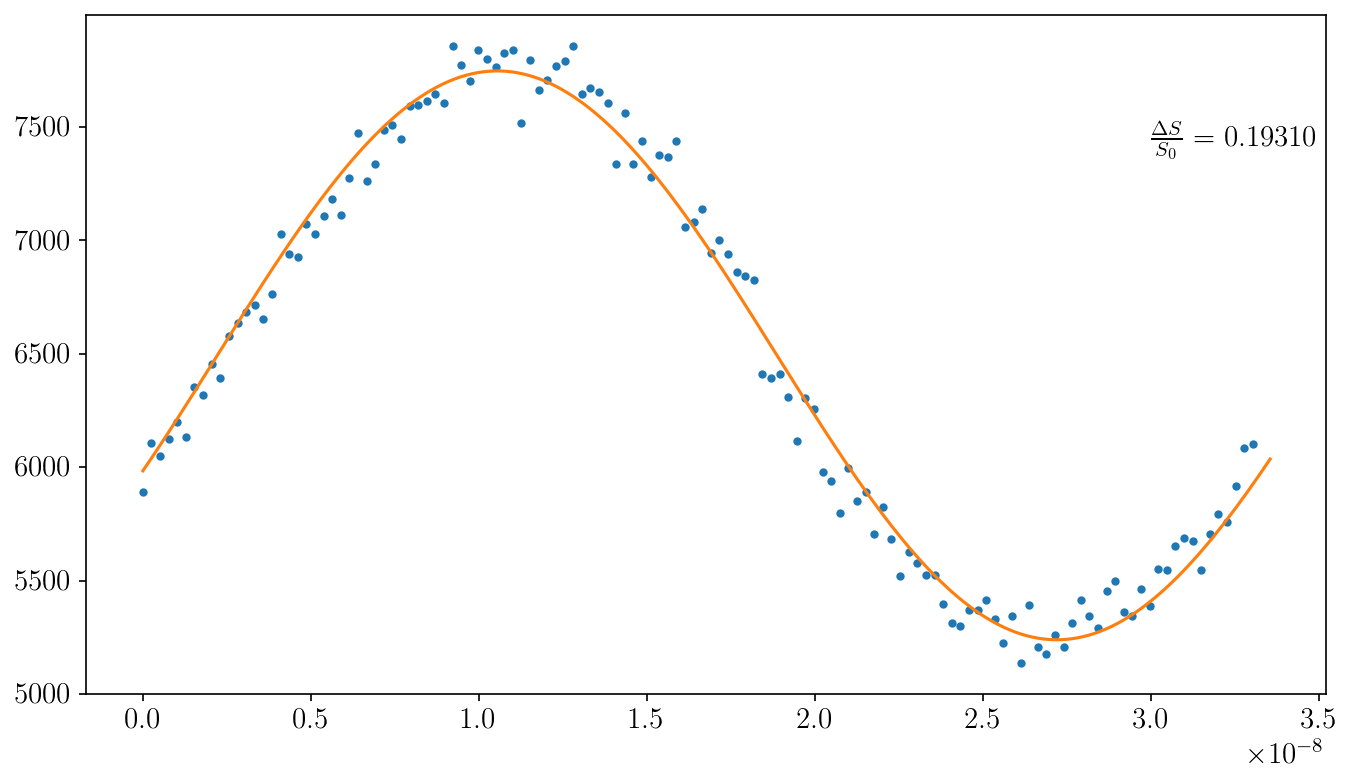

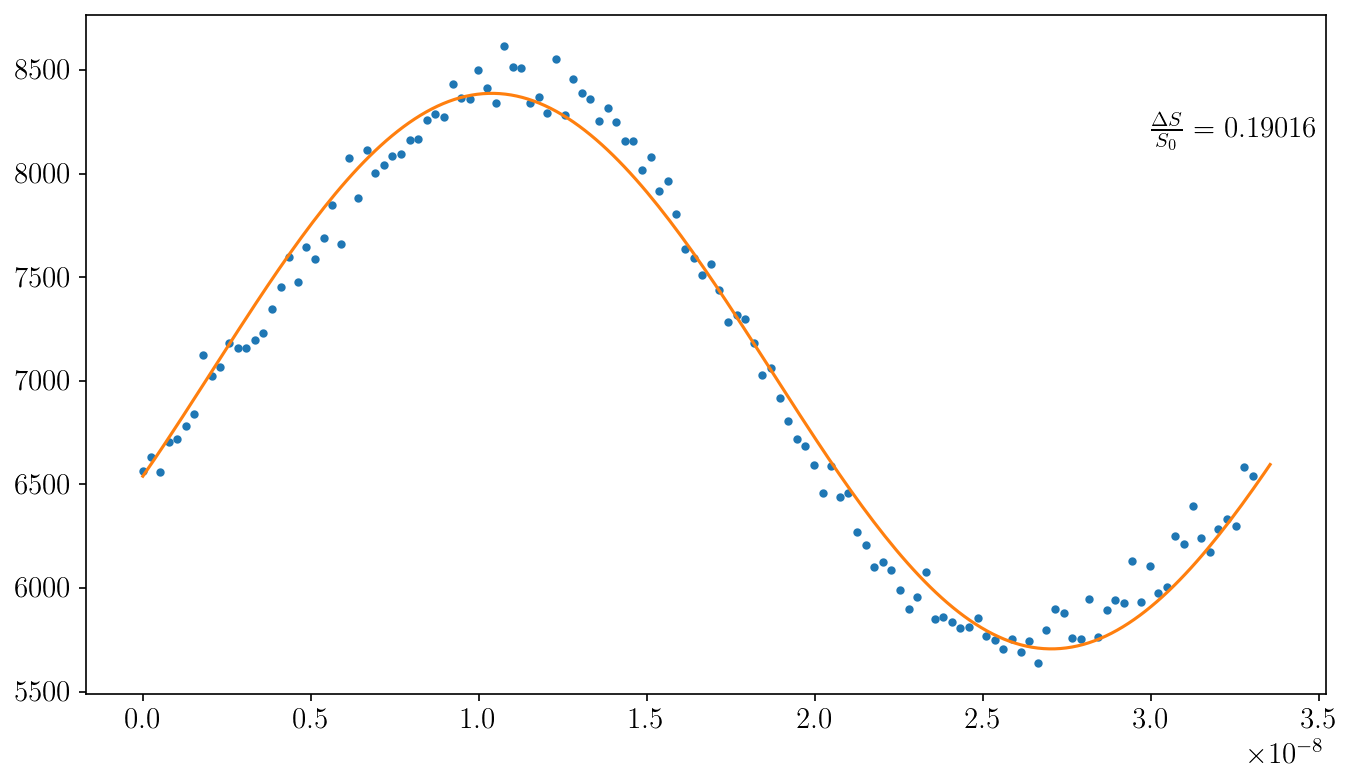

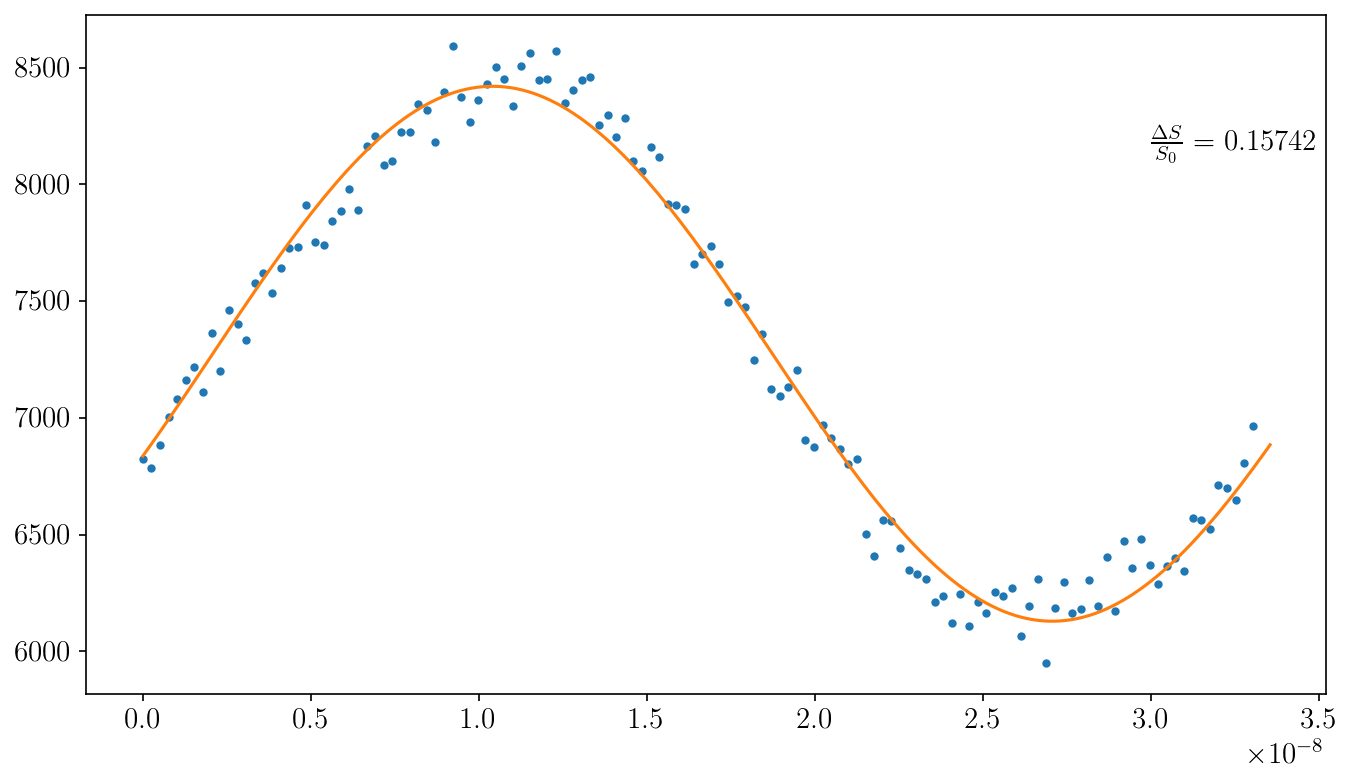

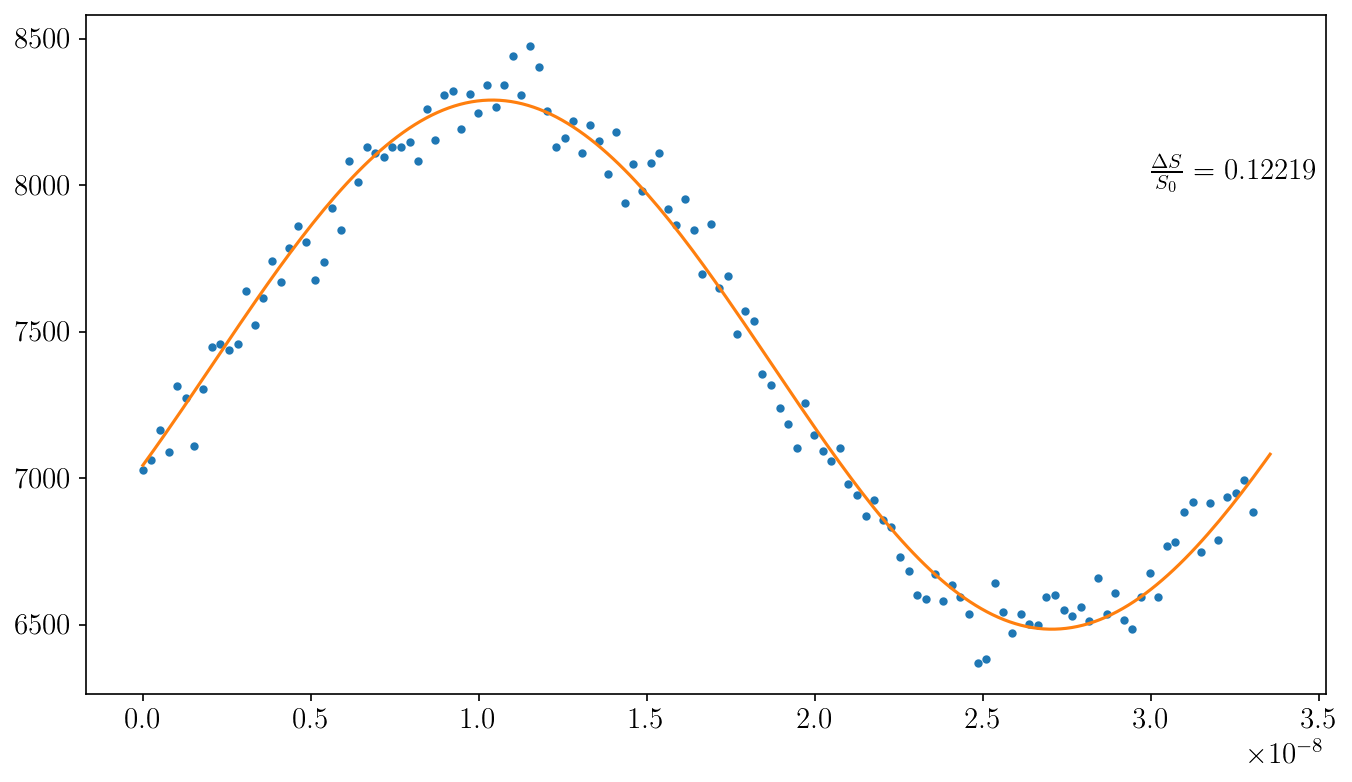

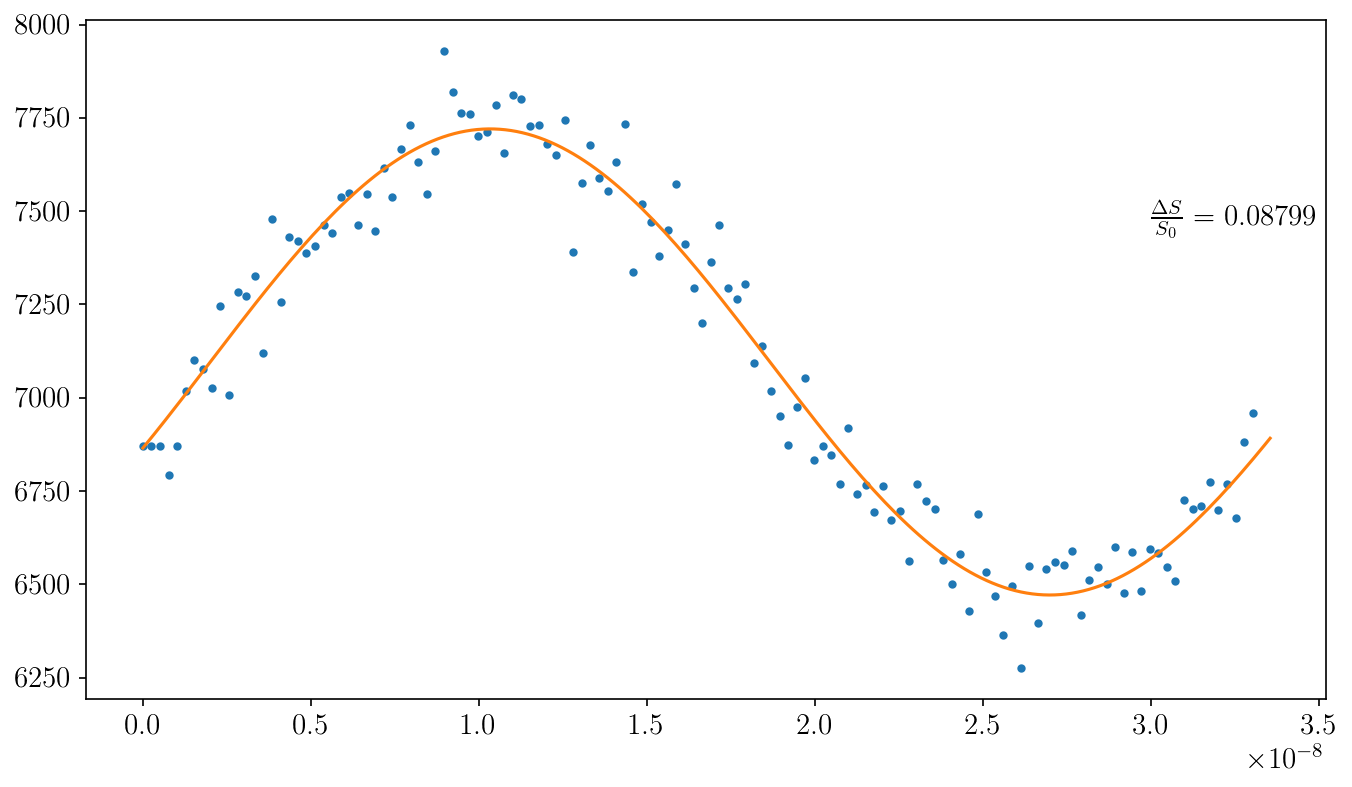

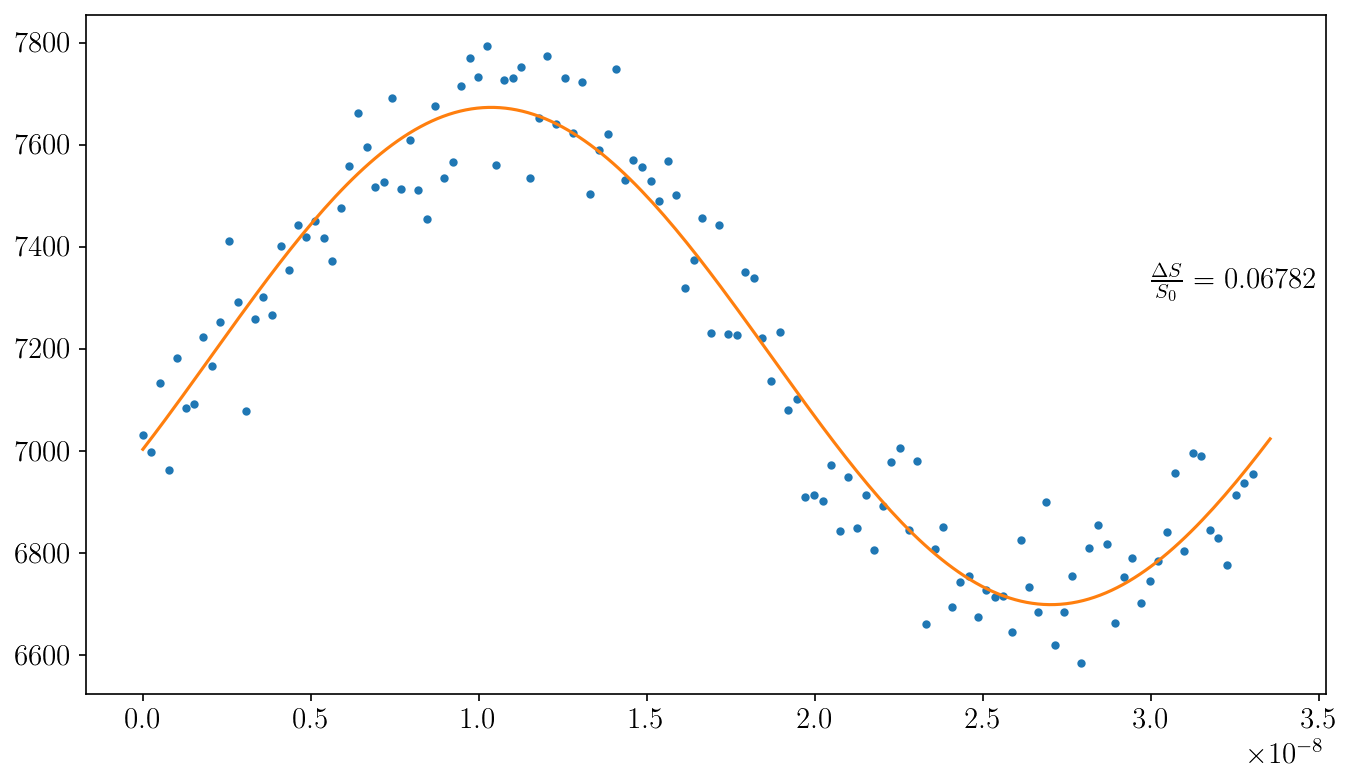

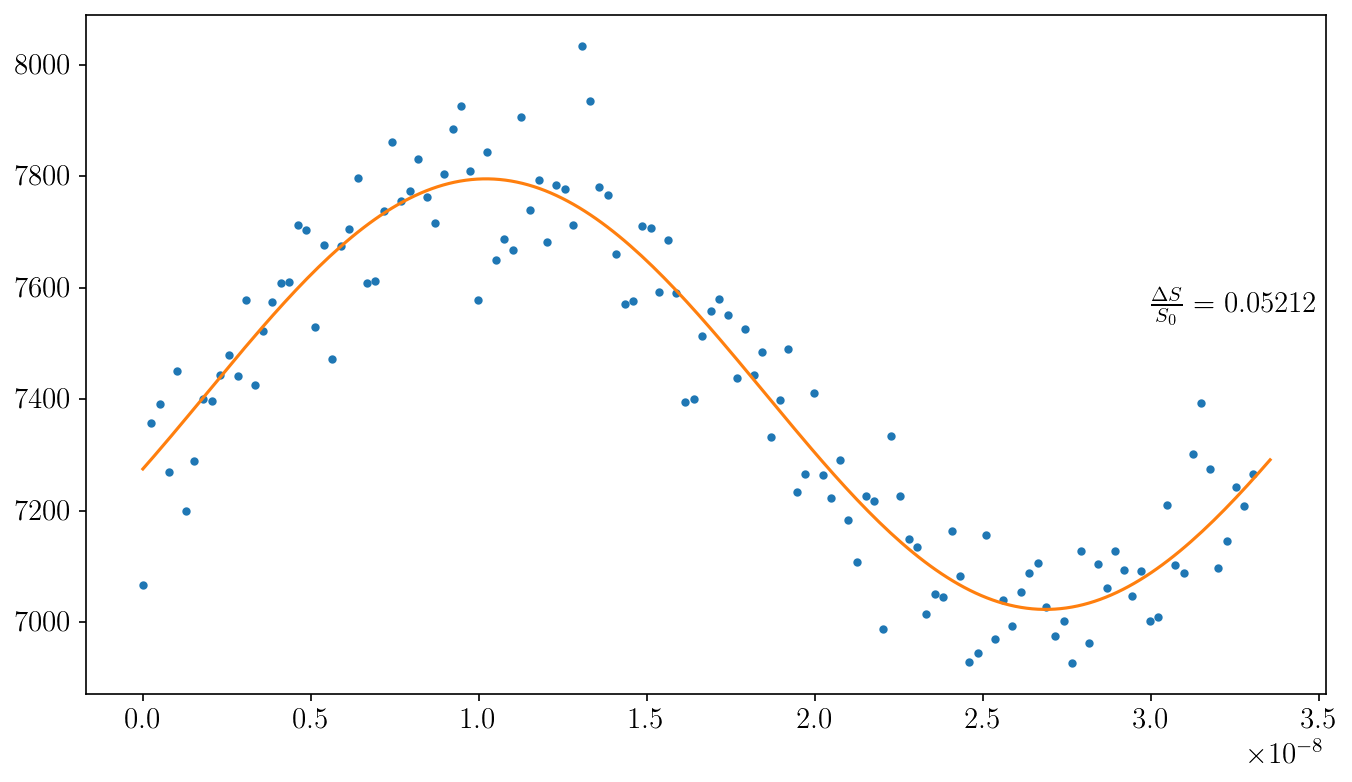

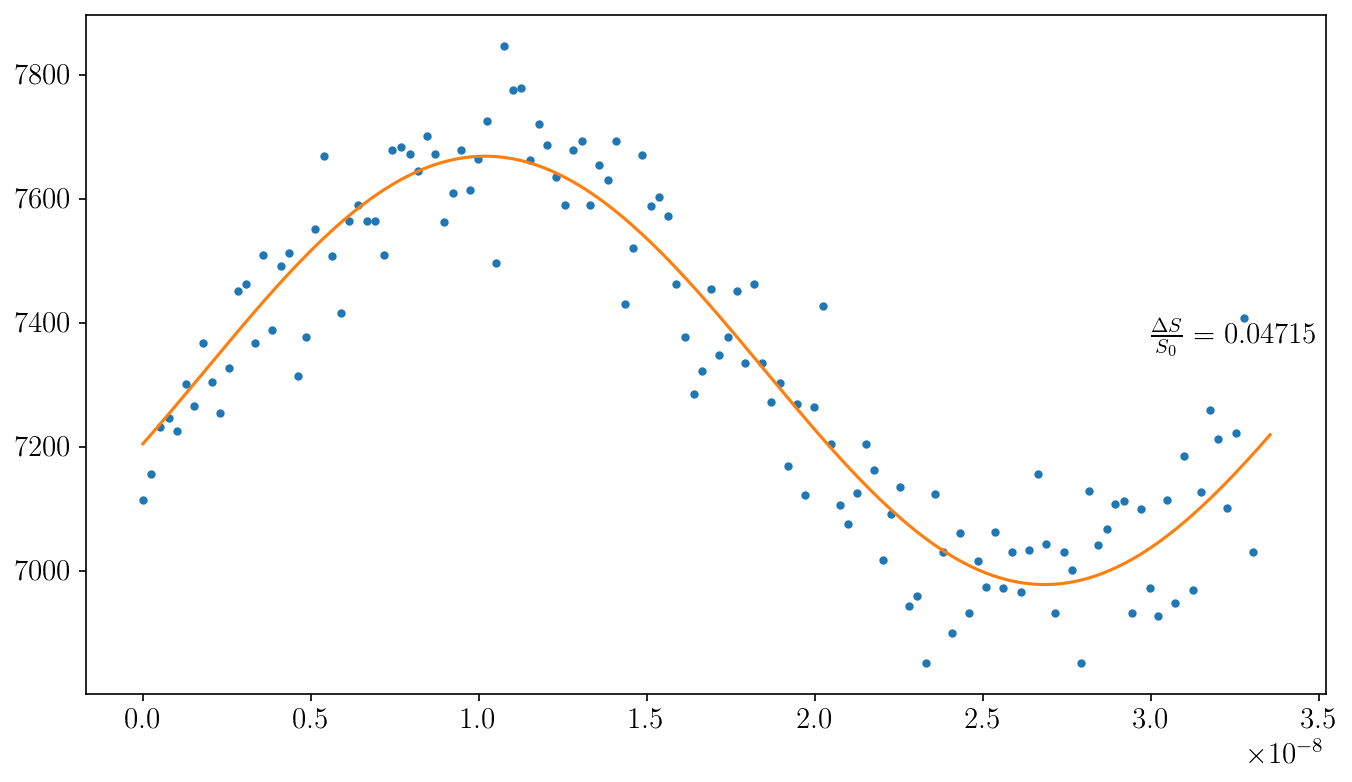

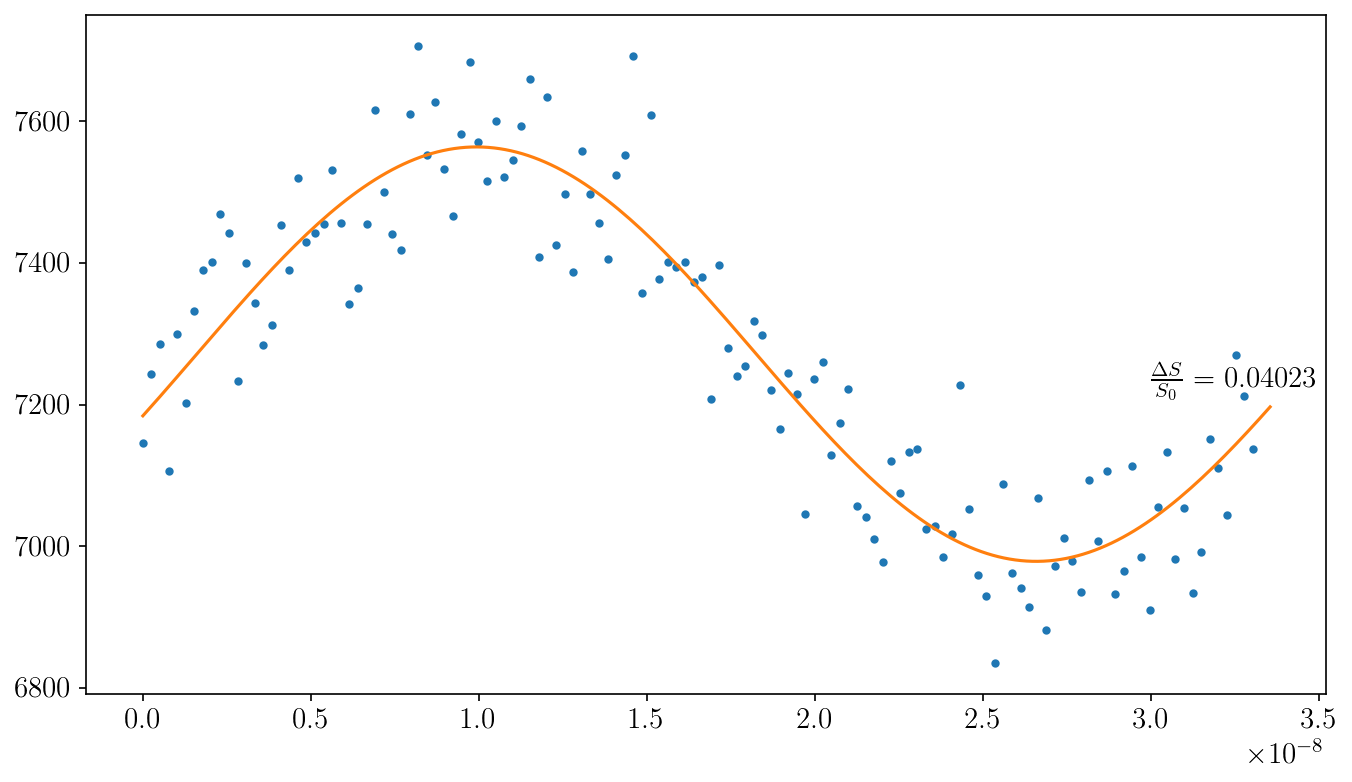

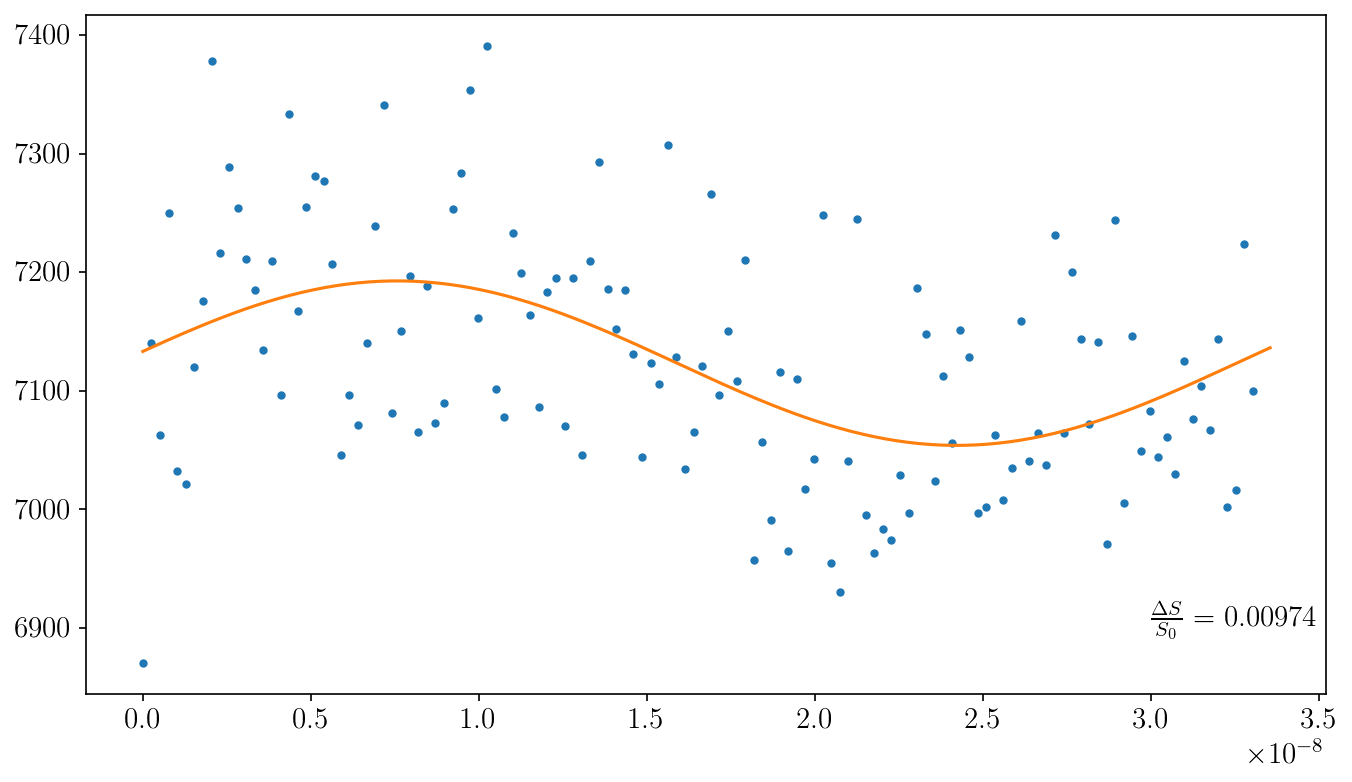

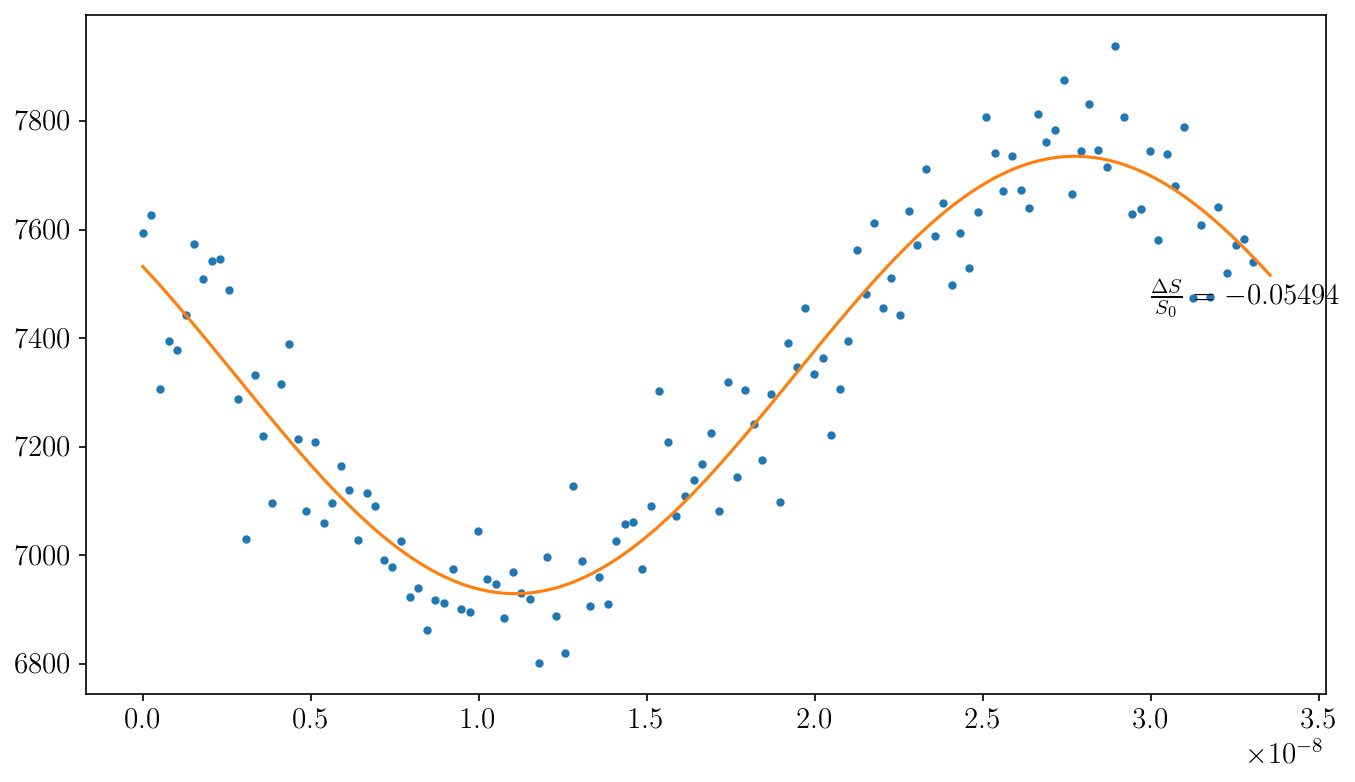

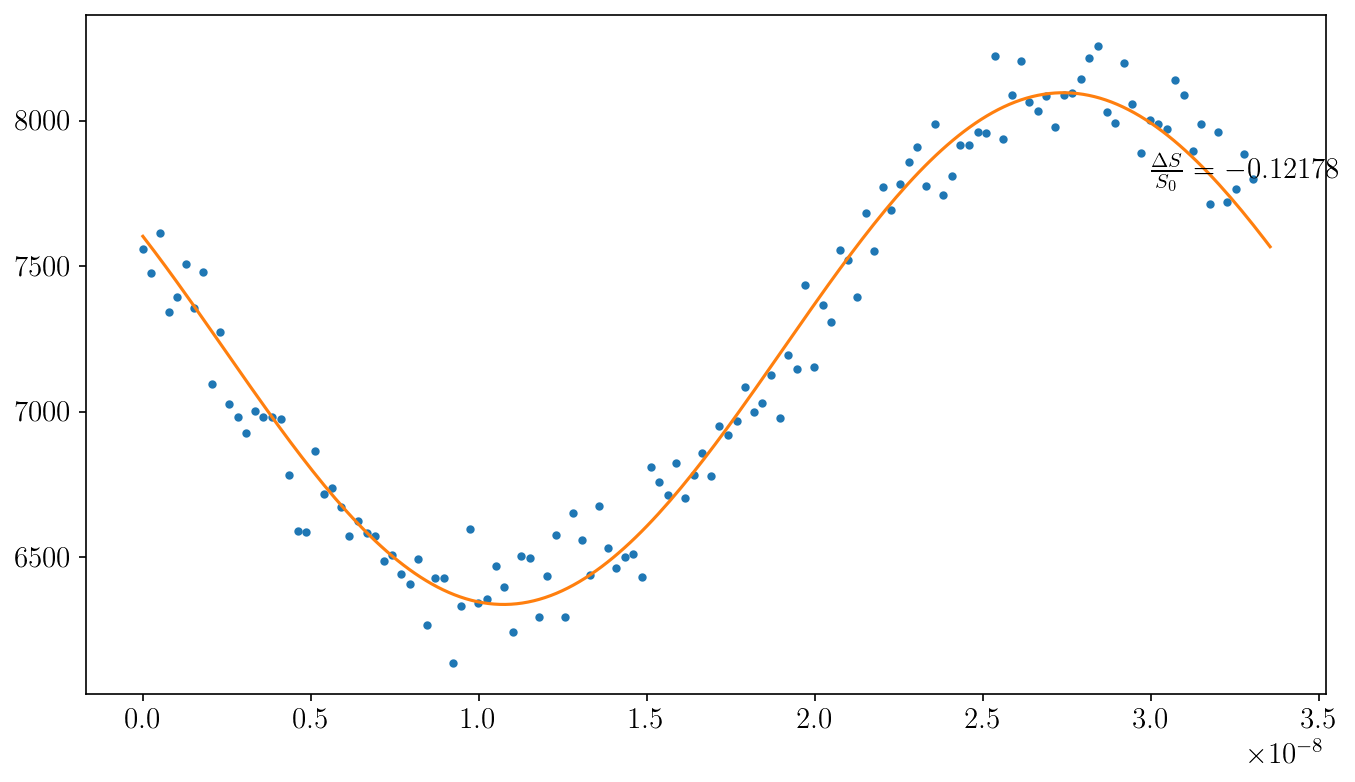

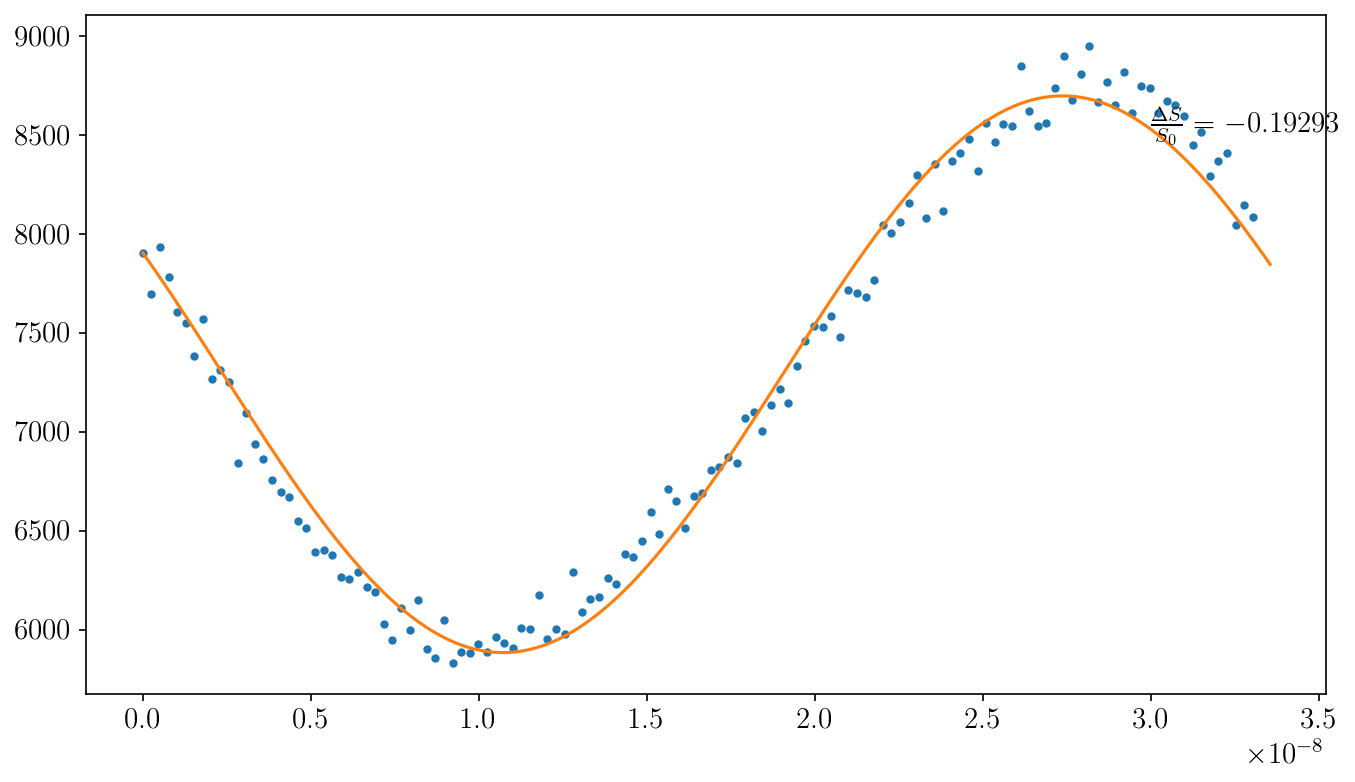

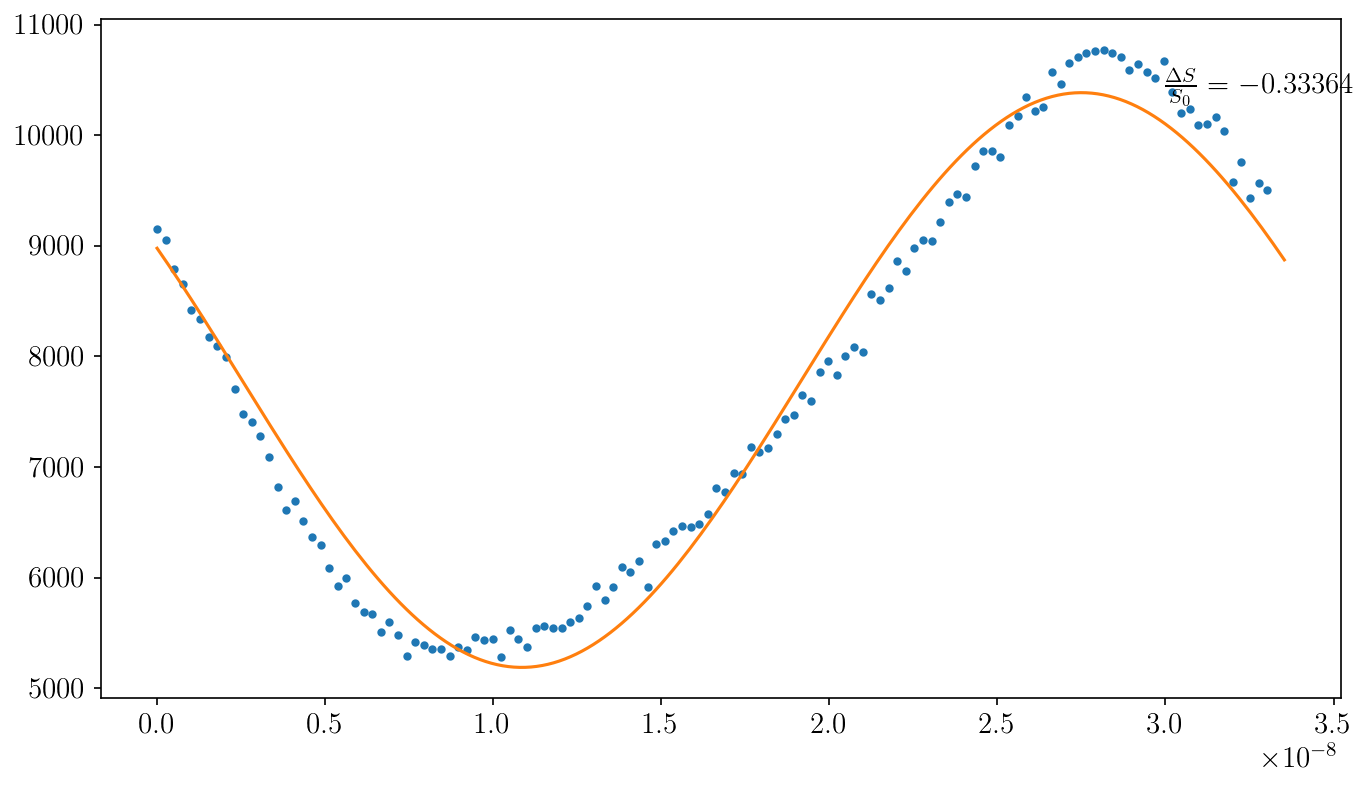

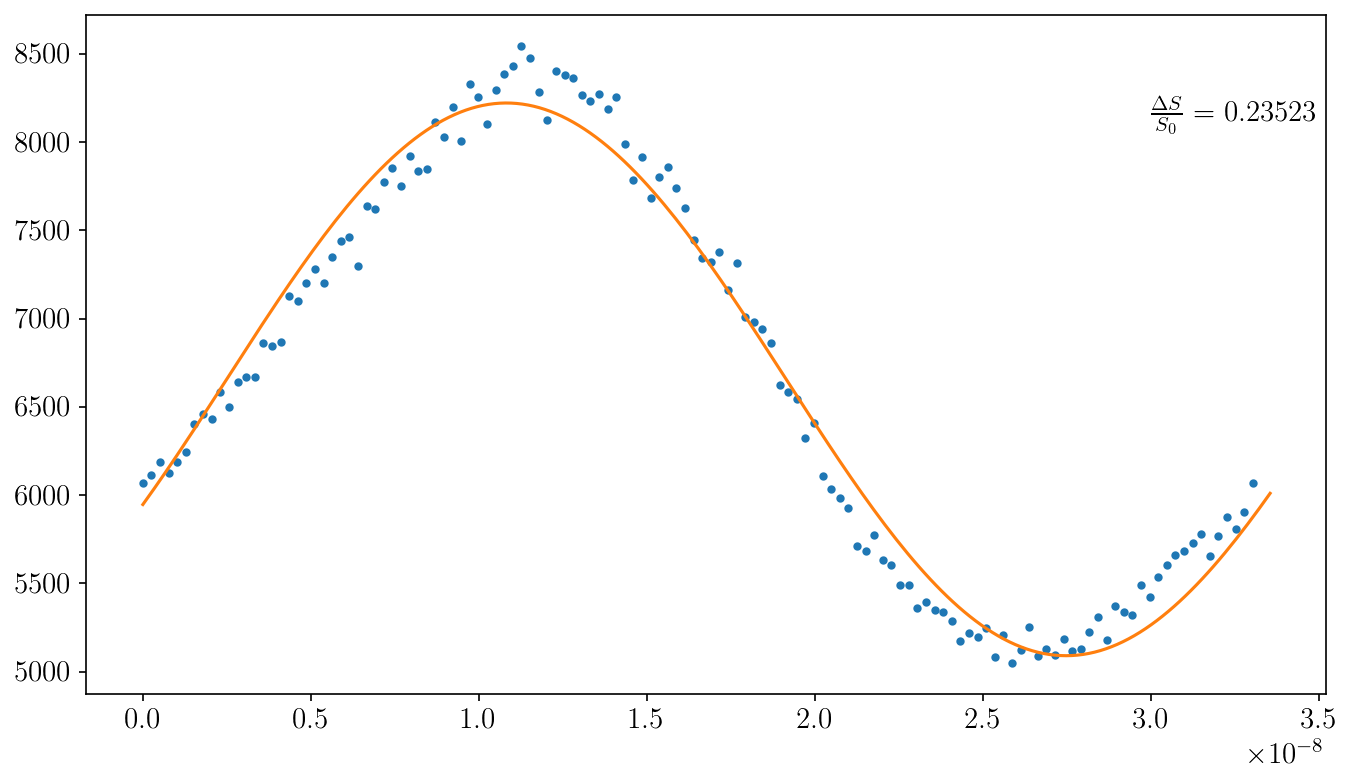

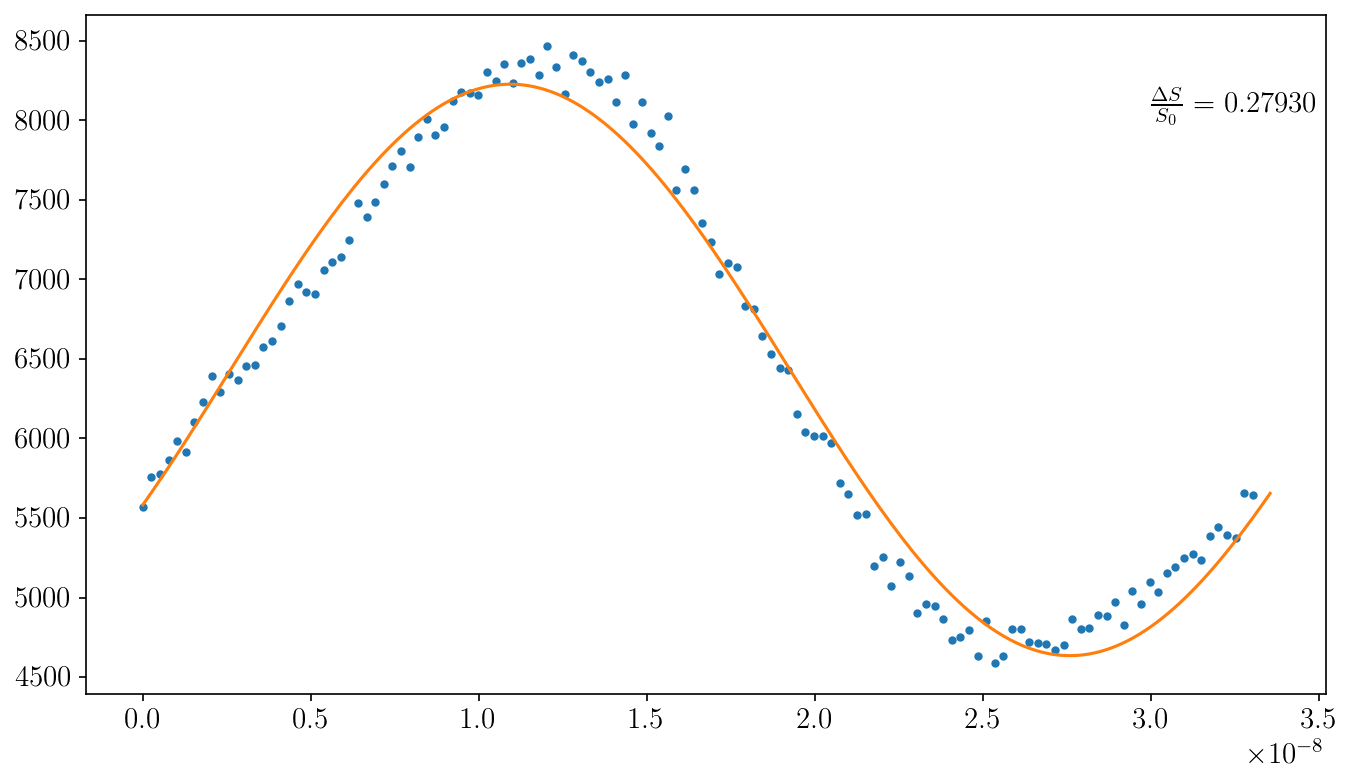

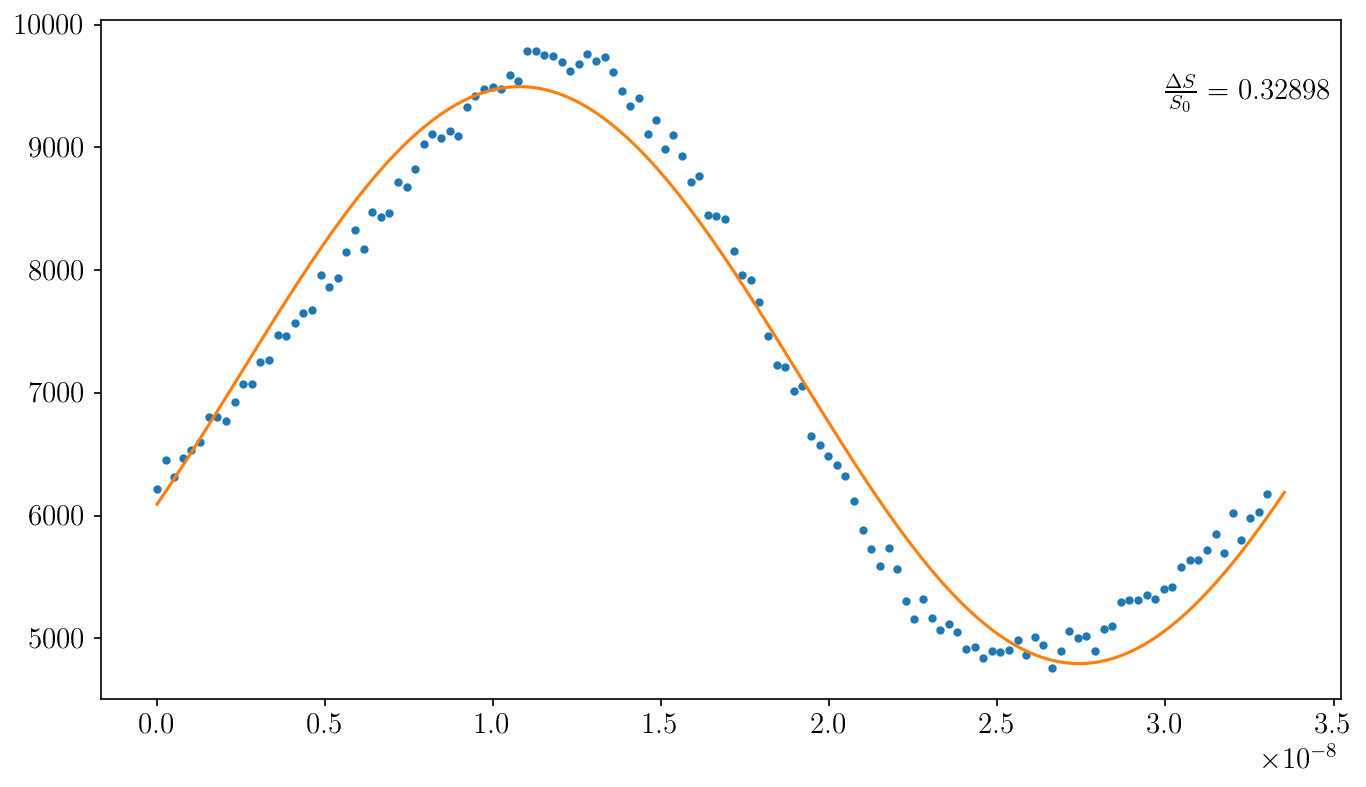

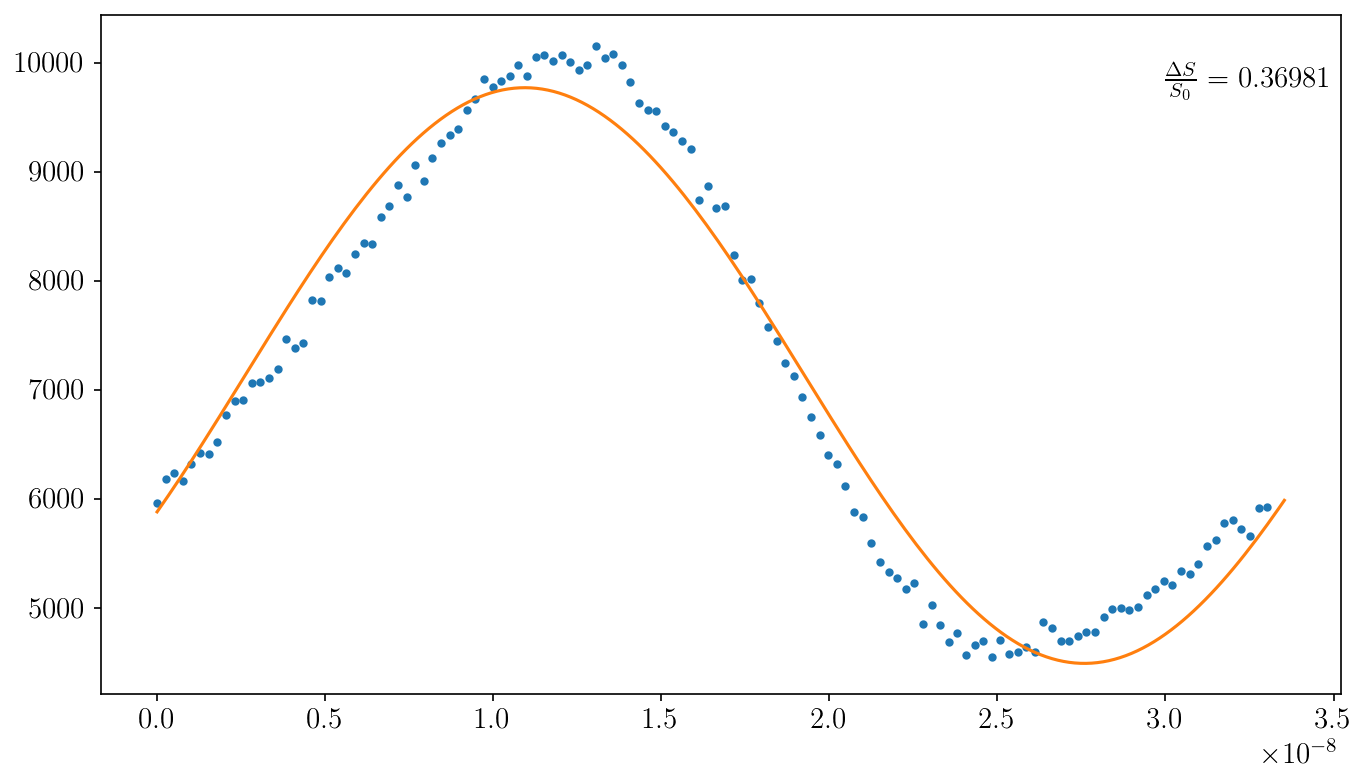

In [9]:
my_dpi = 150
siz = 100
sizex = 16*siz
sizey = 9*siz
# plot techto fitu
time_fit = np.linspace(0, t_scale.max(), 200)

for i in range(fotkor_shape[1]):
    
    fotkor_fit = fit_func(x[:,i], Omega, time_fit)
    
    plt.figure(figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)
    plt.plot(t_scale[:fotkor_shape[0]-2],fotkor_bezcond[:fotkor_shape[0]-2,i],'.')
    plt.plot(time_fit, fotkor_fit)
    text = r'$\frac{\Delta S}{S_0}  = \,\,$' + r'${:.5f}$'.format(x[1,i]/x[0,i])
    plt.text(3e-8, fotkor_bezcond[:,i].max()-500,text) 

Nejmenší MM vykazuje histogram s indexem 9. Na základě tohoto histogramu odhadnu varianci naměřených bodů. Nejprve od všech bodů histogramu odečtu nafitovanou sinusovku, abych dosáhl pokud možno nemodulovaných dat.

In [11]:
x0 = [fotkor_bezcond[:fotkor_shape[0]-2,9].mean(), 0.5* ( fotkor_bezcond[:fotkor_shape[0]-2,9].max()
    -fotkor_bezcond[:fotkor_shape[0]-2,9].min() ), 1.5]

#fit = least_squares(fit_resid,x0, args=(Omega, fotkor_bezcond[:fotkor_shape[0]-2,0], t_res) , method="lm", ftol=1e-10)
fit = least_squares(fit_resid,x0, args=(Omega, fotkor_bezcond[:fotkor_shape[0]-2,9], t_res) , ftol=1e-10, xtol=1e-10)

In [35]:
fotkor_bezcond_noMM = fotkor_bezcond[1:fotkor_shape[0]-2,9] - (fit_func(fit.x, Omega, t_scale[1:fotkor_shape[0]-2])) # data po odecteni modulace

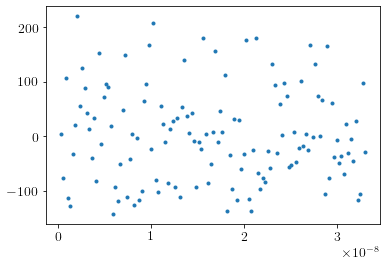

In [36]:
plt.plot(t_scale[1:fotkor_shape[0]-2],fotkor_bezcond_noMM, '.')

to vypada slibne. Ted odhadnu varianci techto bodu.

In [38]:
hist_sigma = np.std(fotkor_bezcond_noMM)
hist_sigma

86.03657527490321

Tuto hodnotu tedy budu predpokladat jako nejistotu bodu histogramu. Ještě ji zkusím ověřit na 8. histogramu.

In [43]:
x0 = [fotkor_bezcond[:fotkor_shape[0]-2,8].mean(), 0.5* ( fotkor_bezcond[:fotkor_shape[0]-2,8].max()
    -fotkor_bezcond[:fotkor_shape[0]-2,8].min() ), 1.5]

#fit = least_squares(fit_resid,x0, args=(Omega, fotkor_bezcond[:fotkor_shape[0]-2,0], t_res) , method="lm", ftol=1e-10)
fit = least_squares(fit_resid,x0, args=(Omega, fotkor_bezcond[:fotkor_shape[0]-2,8], t_res) , ftol=1e-10, xtol=1e-10)
fotkor_bezcond_noMM = fotkor_bezcond[1:fotkor_shape[0]-2,8] - (fit_func(fit.x, Omega, t_scale[1:fotkor_shape[0]-2])) # data po odecteni modulace
np.std(fotkor_bezcond_noMM)

81.09953614475

V poradku.

## Fitování histogramů včetně odhadu nejistot

Proces fitování musím upravit tak, abych mohl odhadnout nejistoty, tzn. přidávám váhy. Dále pak budu do grafů přidávat errorbary.

In [44]:
# residua vcetne vah
# funkce vracejici residua
def fit_resid_weight(x,W_vec, Omega, S, time_step):
    # x = [S_0, Delta S, phi]
    # W_vec .. vektor vah prislusejicich jednotlivym bodum
    len_S = len(S)
    #print(len_S)
    S_fit = x[0] + x[1] * np.cos(Omega * time_step * np.arange(0, len_S) - x[2])
    return( np.sqrt(W_vec) * (S - S_fit) )

In [192]:
#from scipy.optimize import least_squares
# cyklus fitujici vsechny foton-korelacni data

x = np.zeros( (3,fotkor_shape[1]) )
DeltaS_S_ratio = []
sigmas = np.zeros((3,fotkor_shape[1]))
Delta_S_S_ratio_sigma = []

W_vec = 1/hist_sigma**2 * np.ones(fotkor_shape[0]-2)
#W_vec = 1/100**2 * np.ones(fotkor_shape[0]-2)
for i in range(fotkor_shape[1]):
    x0 = [fotkor_bezcond[:fotkor_shape[0]-2,i].mean(), 0.5* ( fotkor_bezcond[:fotkor_shape[0]-2,i].max()
        -fotkor_bezcond[:fotkor_shape[0]-2,i].min() ), 1.5]
#     W_vec = 1/hist_sigma**2 * np.ones(fotkor_shape[0]-2)

    #fit = least_squares(fit_resid,x0, args=(Omega, fotkor_bezcond[:fotkor_shape[0]-2,0], t_res) , method="lm", ftol=1e-10)
    fit = least_squares(fit_resid_weight,x0, args=(W_vec,Omega, fotkor_bezcond[:fotkor_shape[0]-2,i], t_res) , ftol=1e-10, xtol=1e-10)
    
    #---- odhad nejistot parametru----
    jac = fit.jac
    C = np.linalg.inv( np.matmul( np.transpose(jac), np.matmul( np.diag(W_vec), jac ) ) )  # variancni-kovariancni matice
    resid_sq = fit.fun**2   # residua na druhou
    g_fit = resid_sq.sum() * 1/( len(W_vec) - 3)   # goodnes of fit
    #-------------------------------
    
    
    x[:,i] = fit.x
    sigmas[:,i] = np.sqrt( np.diagonal(C) )
    DeltaS_S_ratio.append(x[1,i]/x[0,i]  )
    
    #---- sigma delta s ku s
    S0 = fit.x[0]
    DeltaS = fit.x[1]
    Delta_S_S_ratio_sigma.append(np.sqrt( 1/S0**2 * C[0,0] + (DeltaS**2 / S0**4)*C[1,1] -2*(DeltaS/S0**3)*C[0,1]) )
    
    
DeltaS = np.array(DeltaS)
Delta_S_S_ratio_sigma = np.array(Delta_S_S_ratio_sigma)

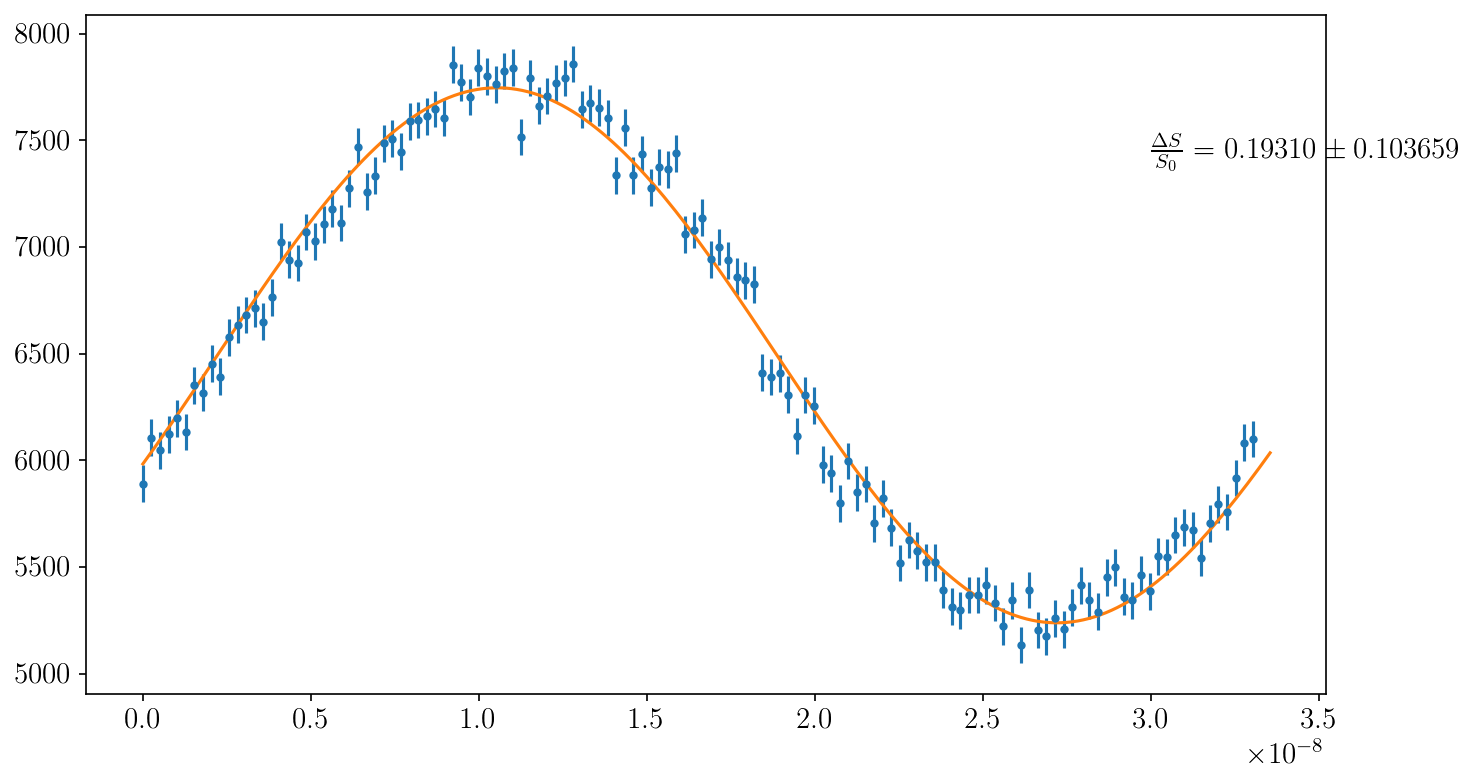

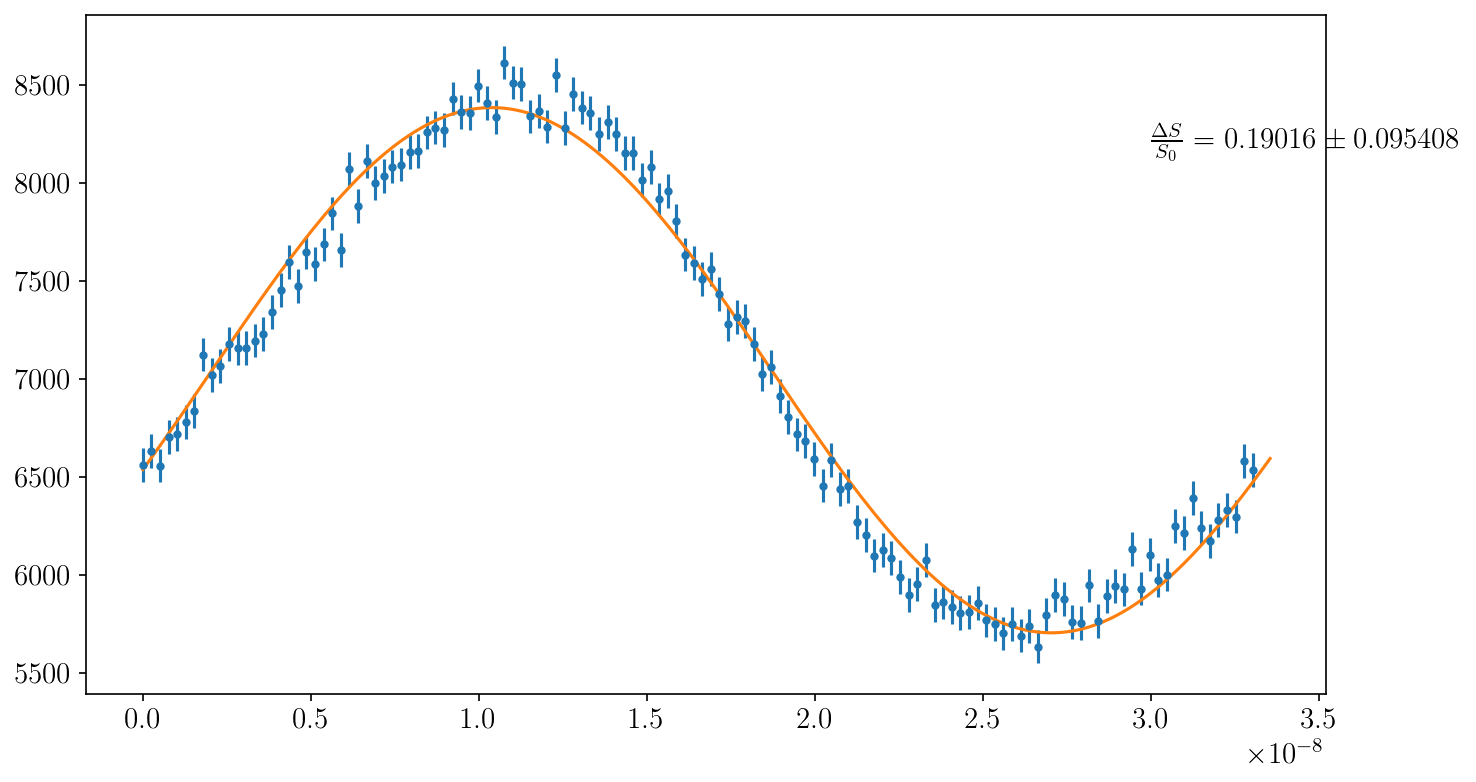

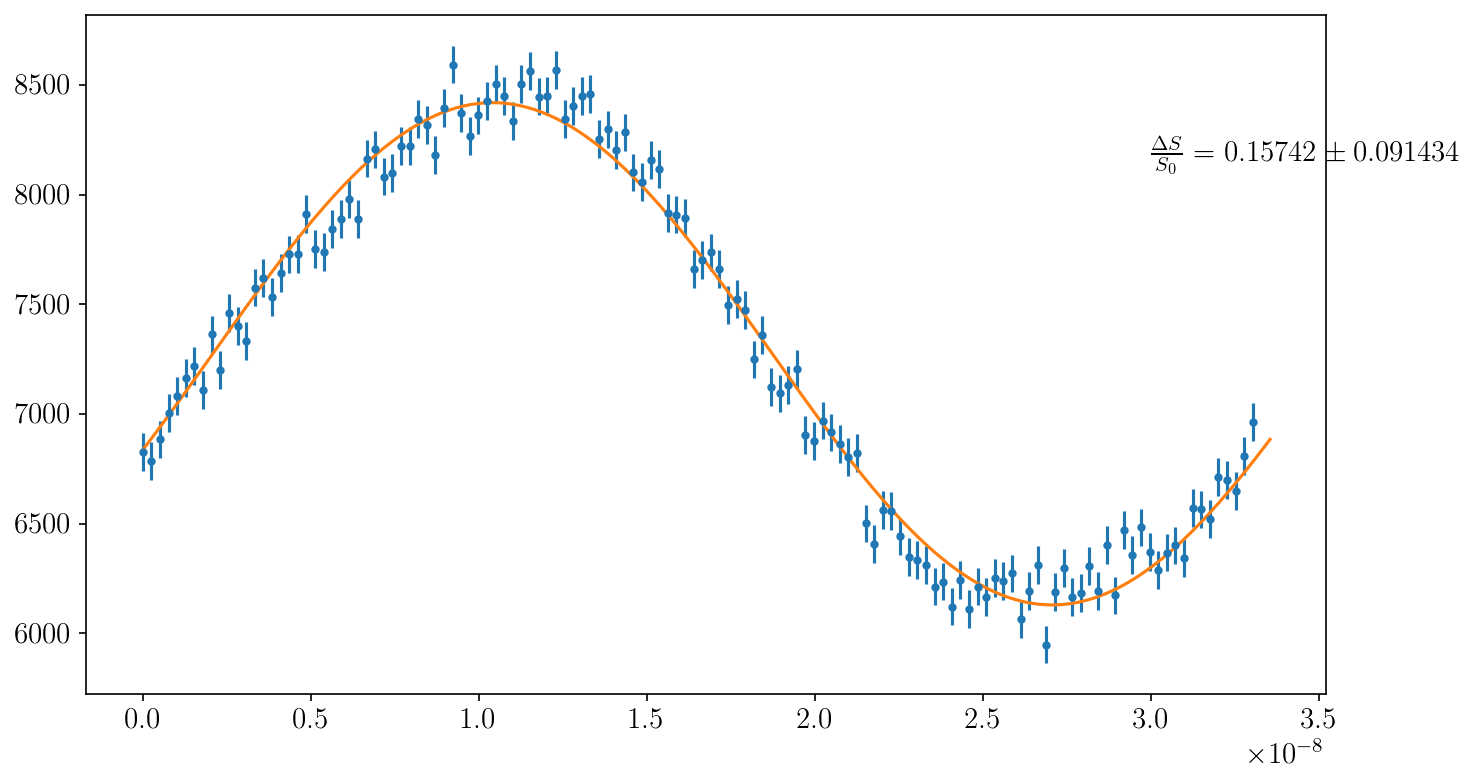

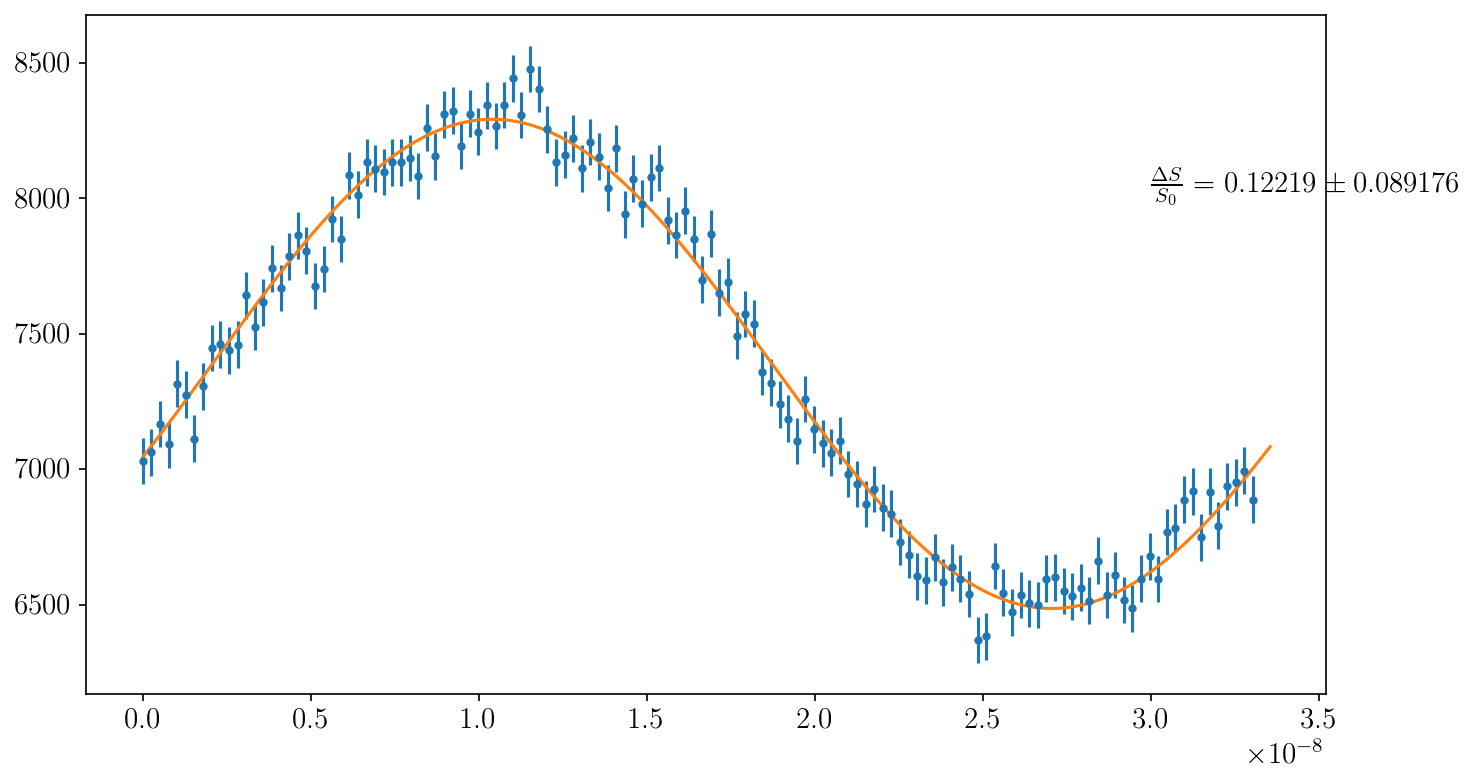

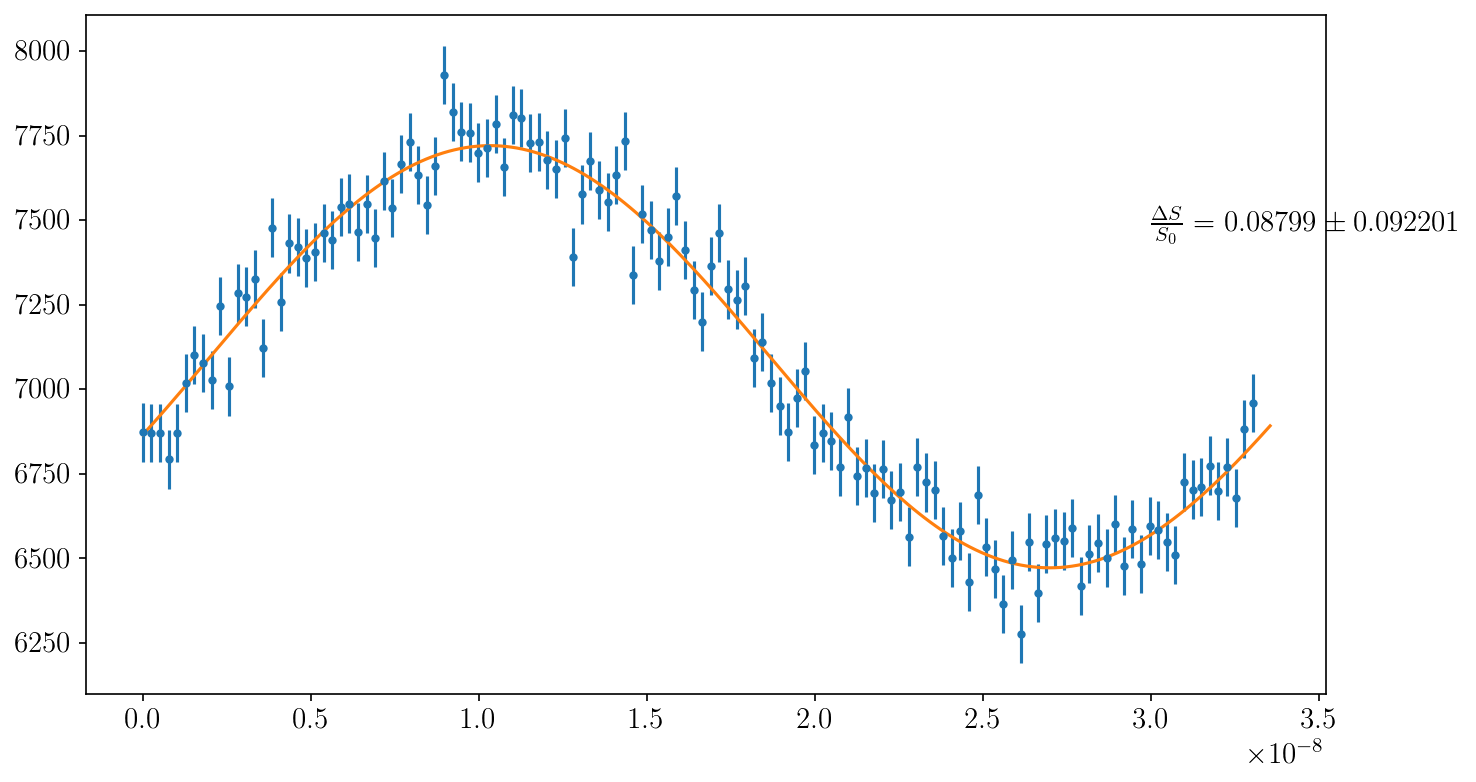

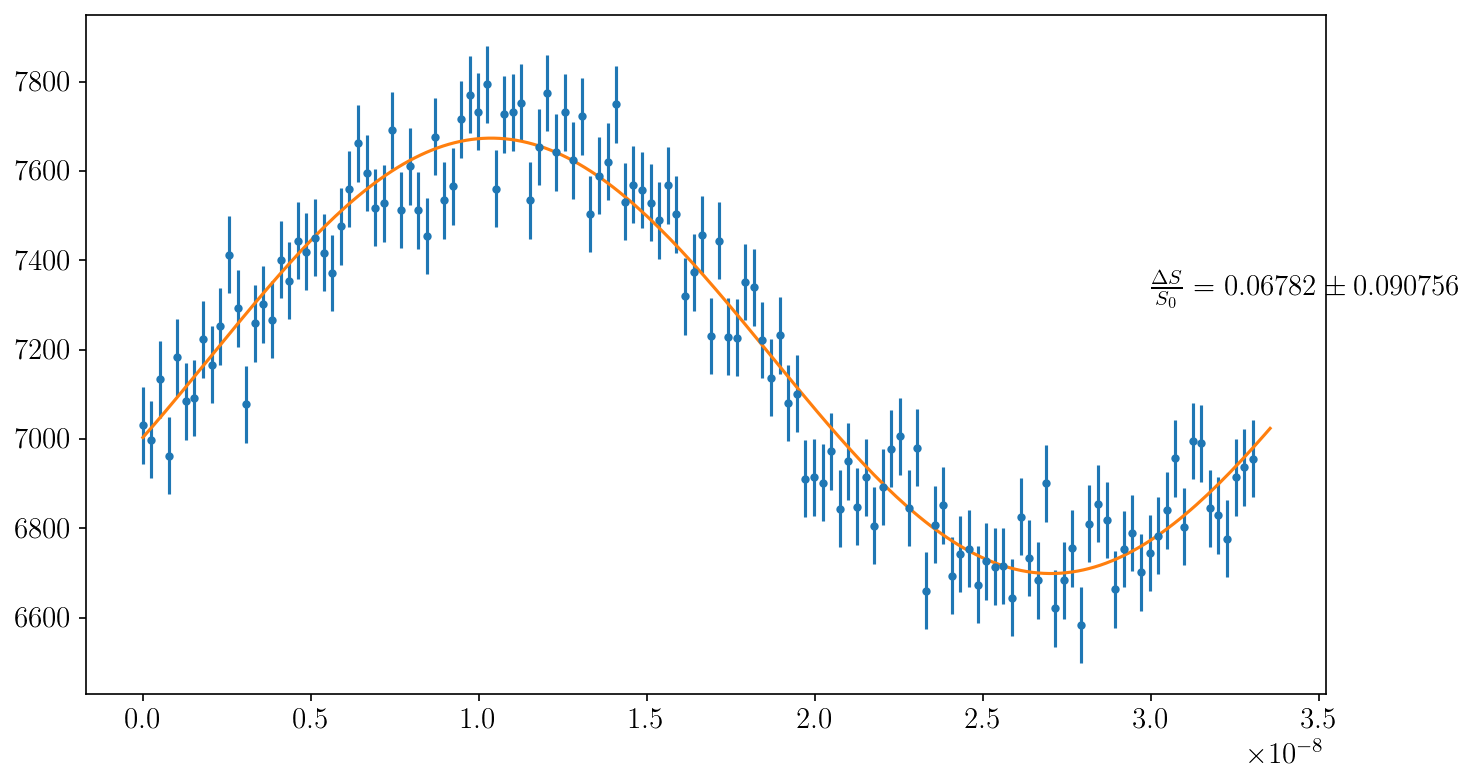

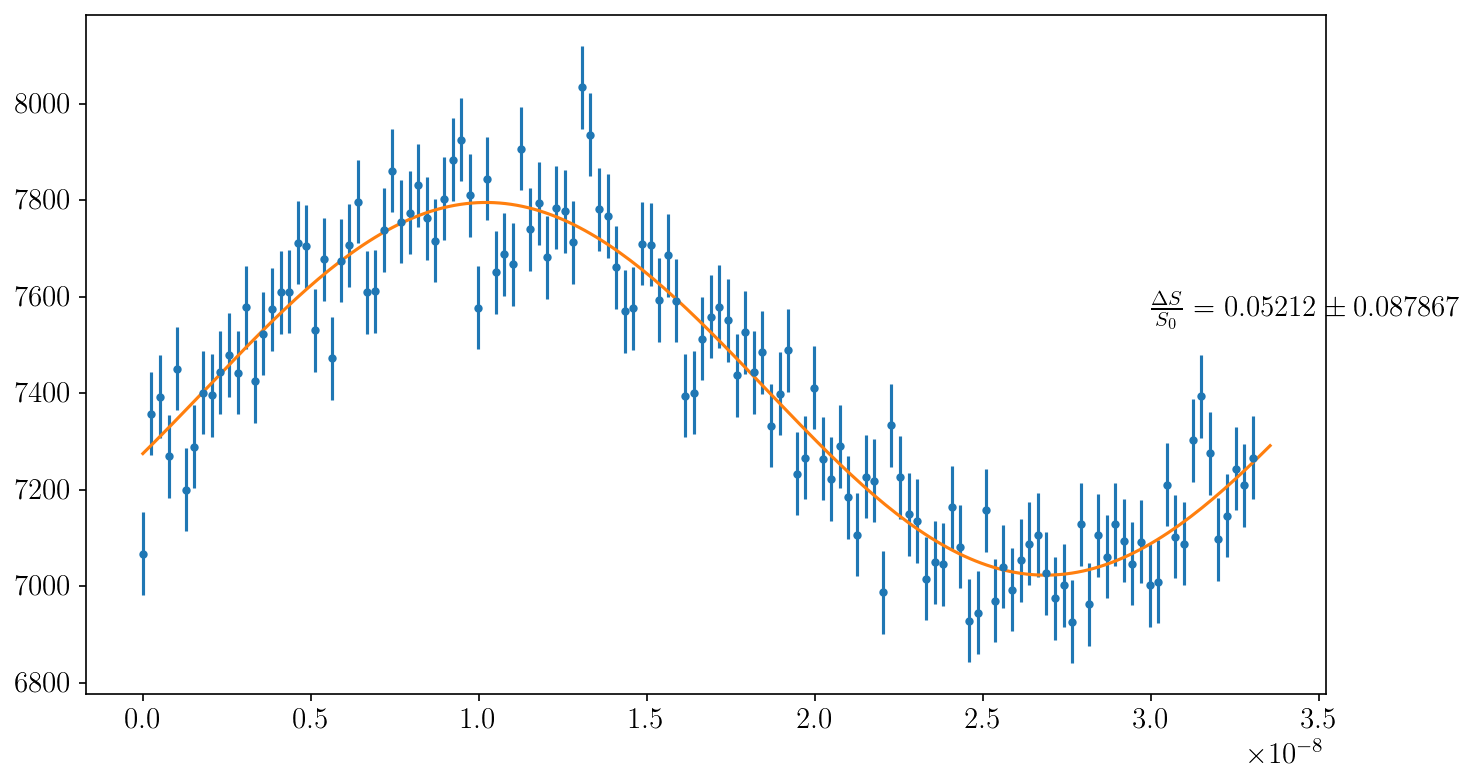

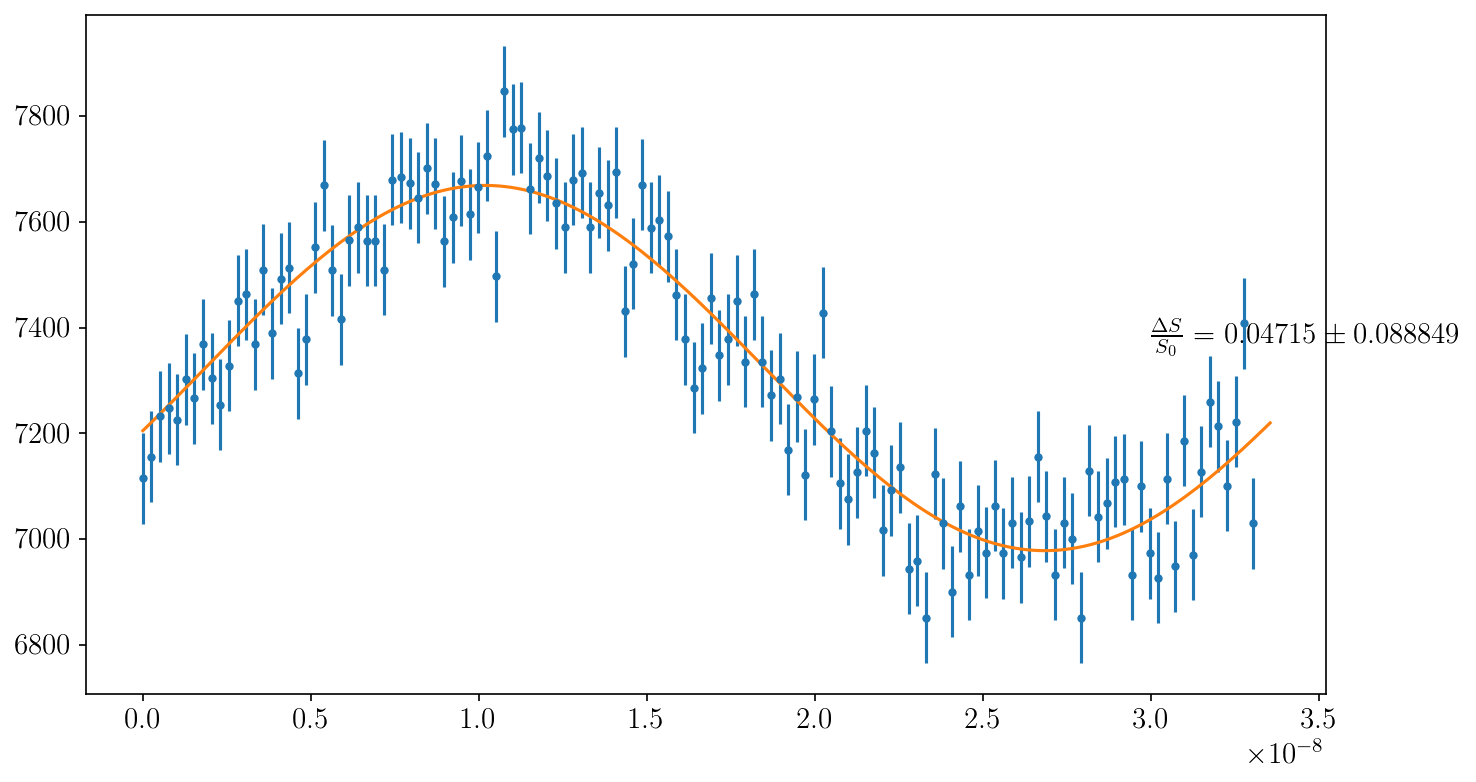

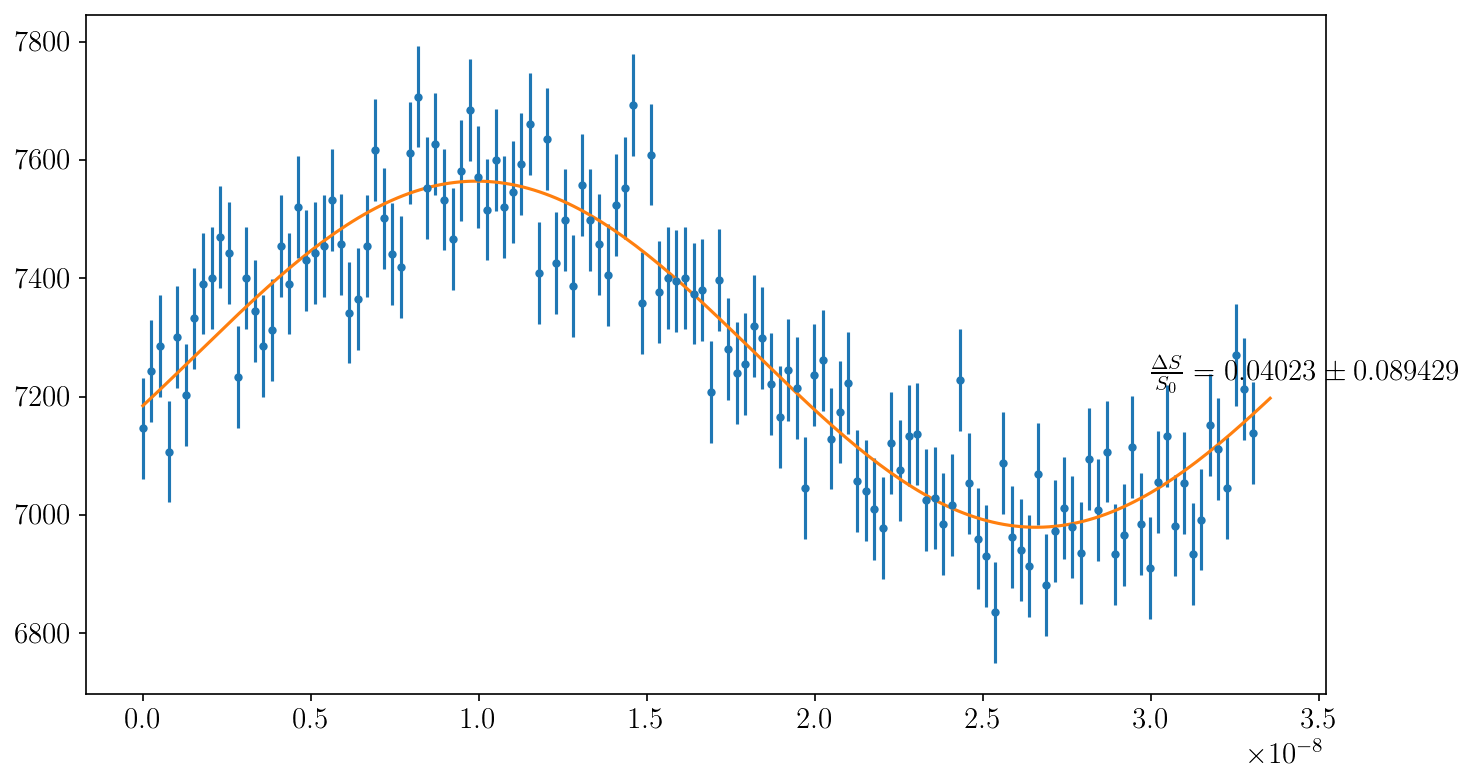

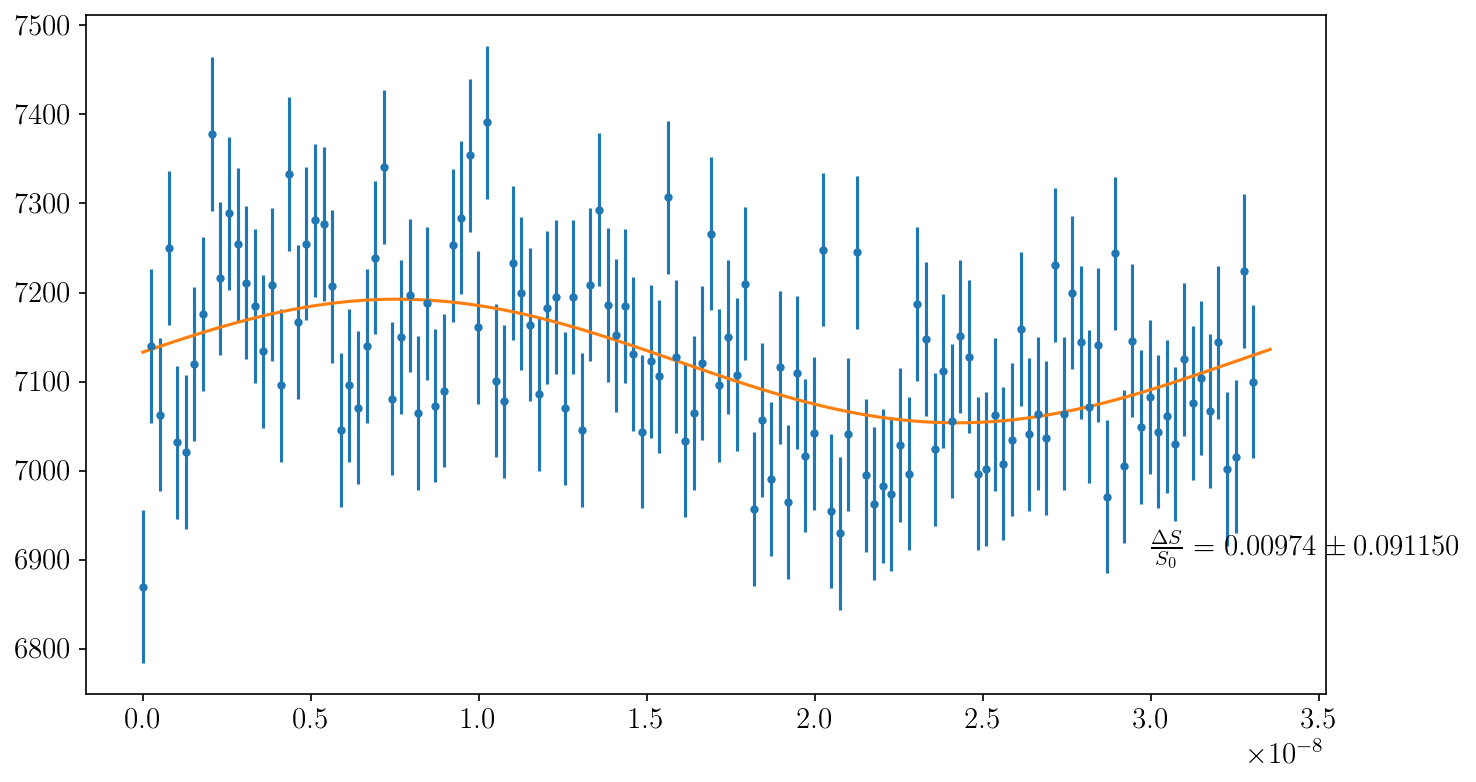

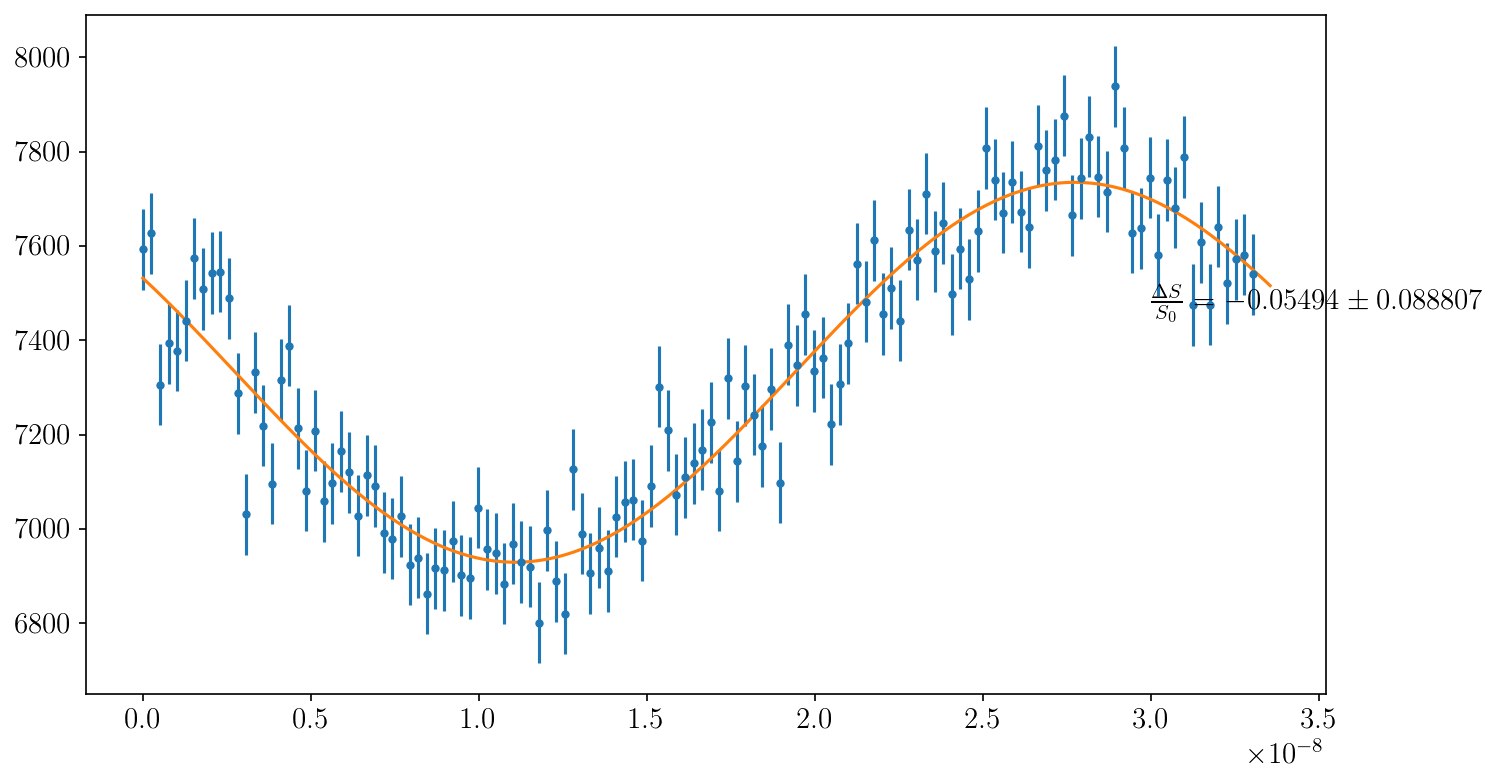

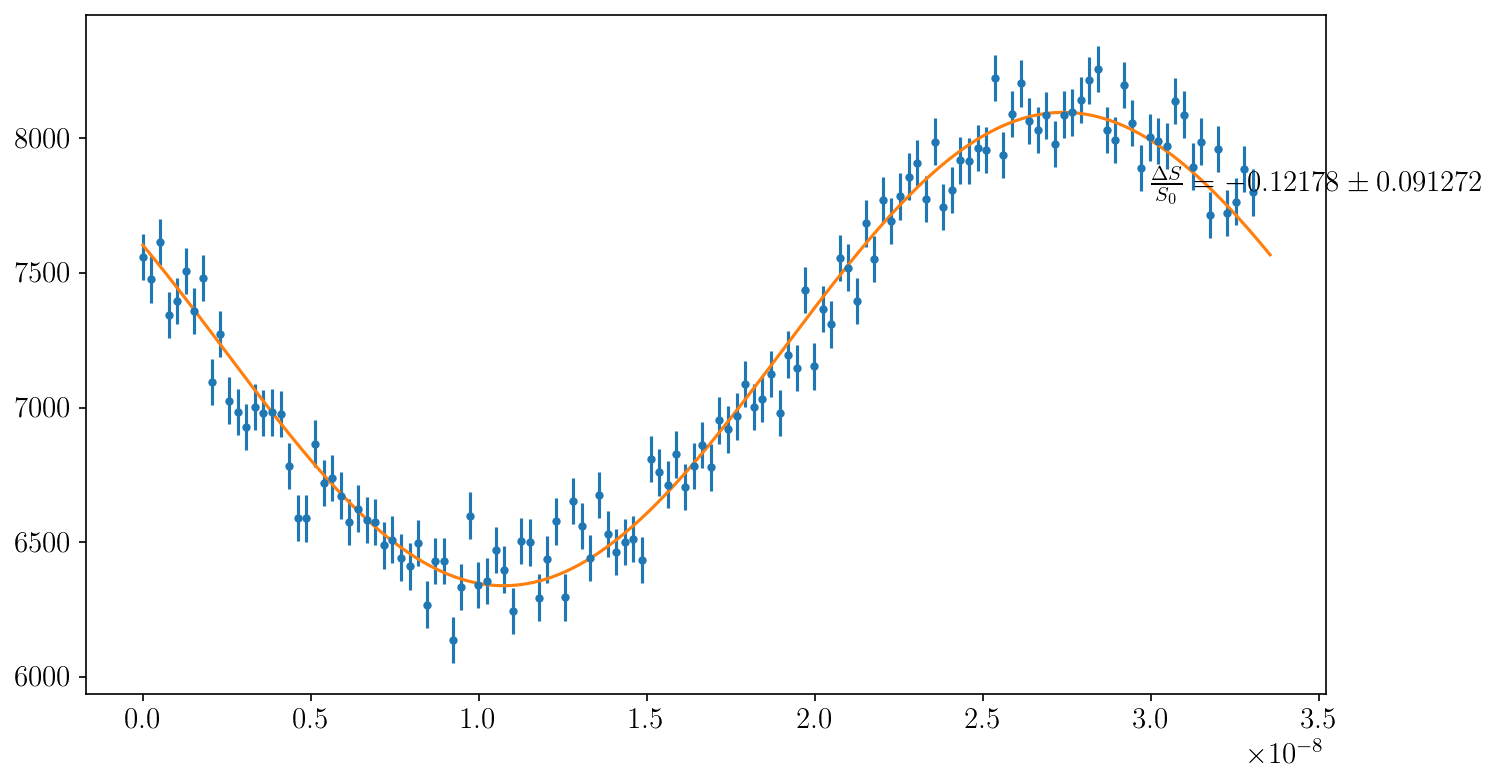

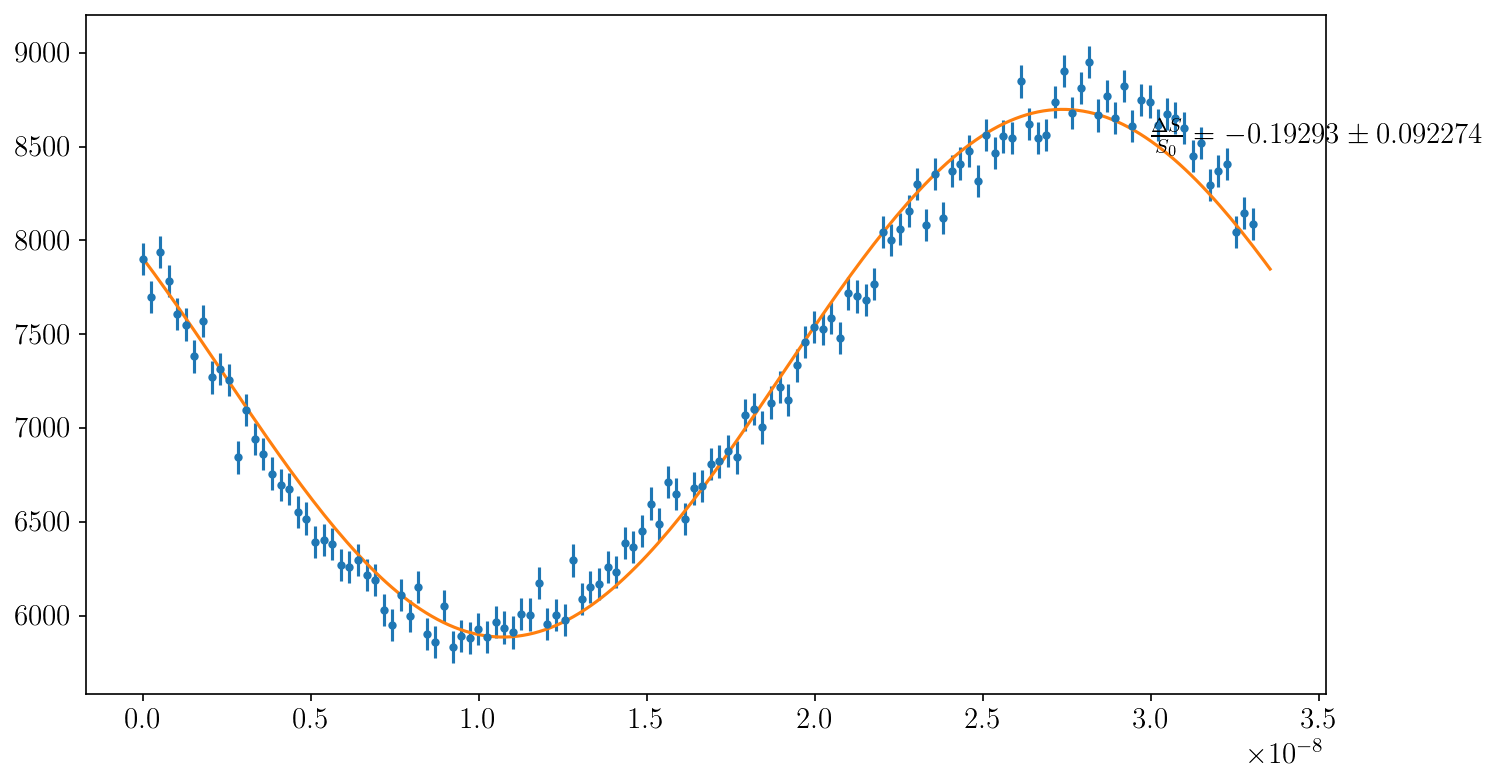

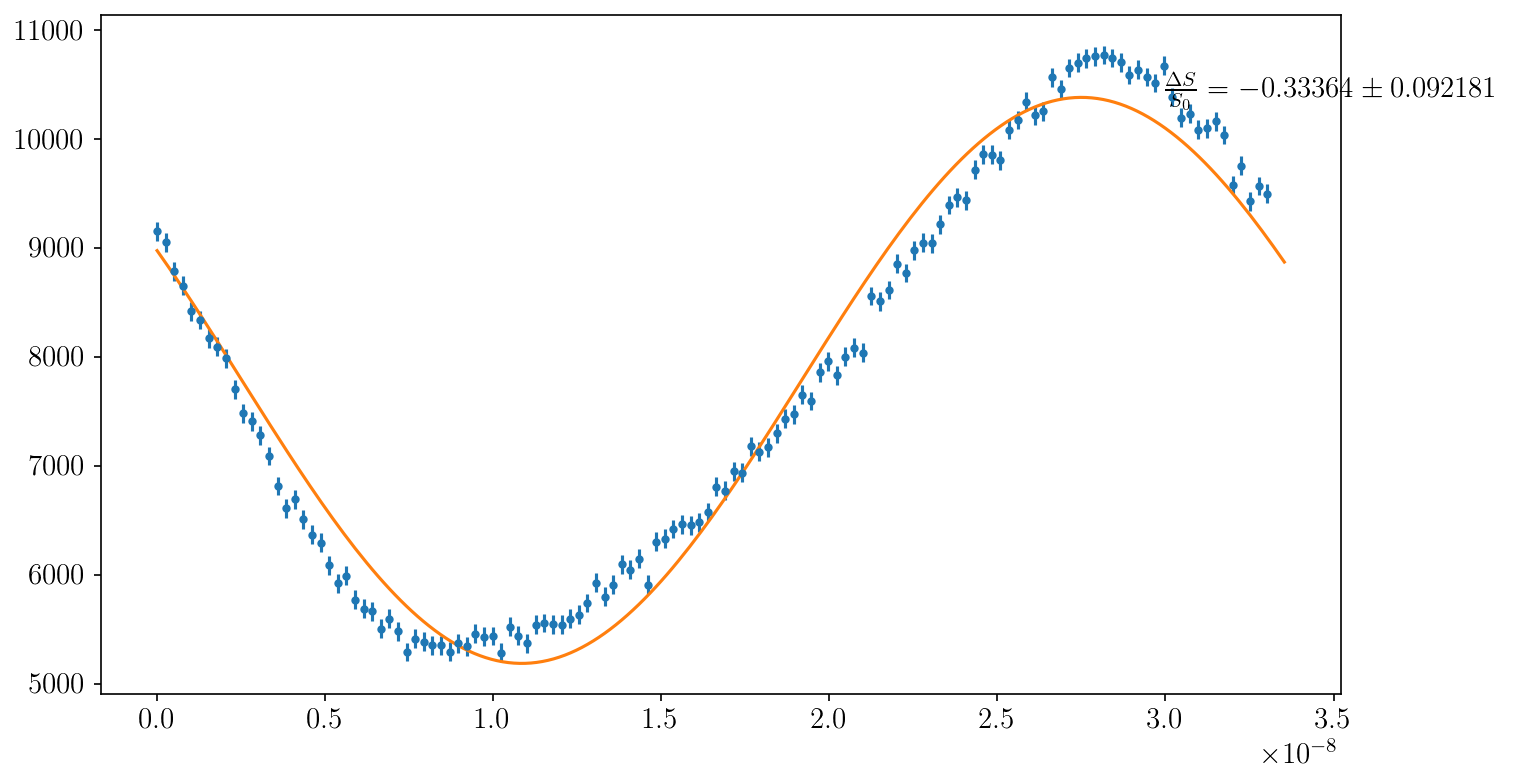

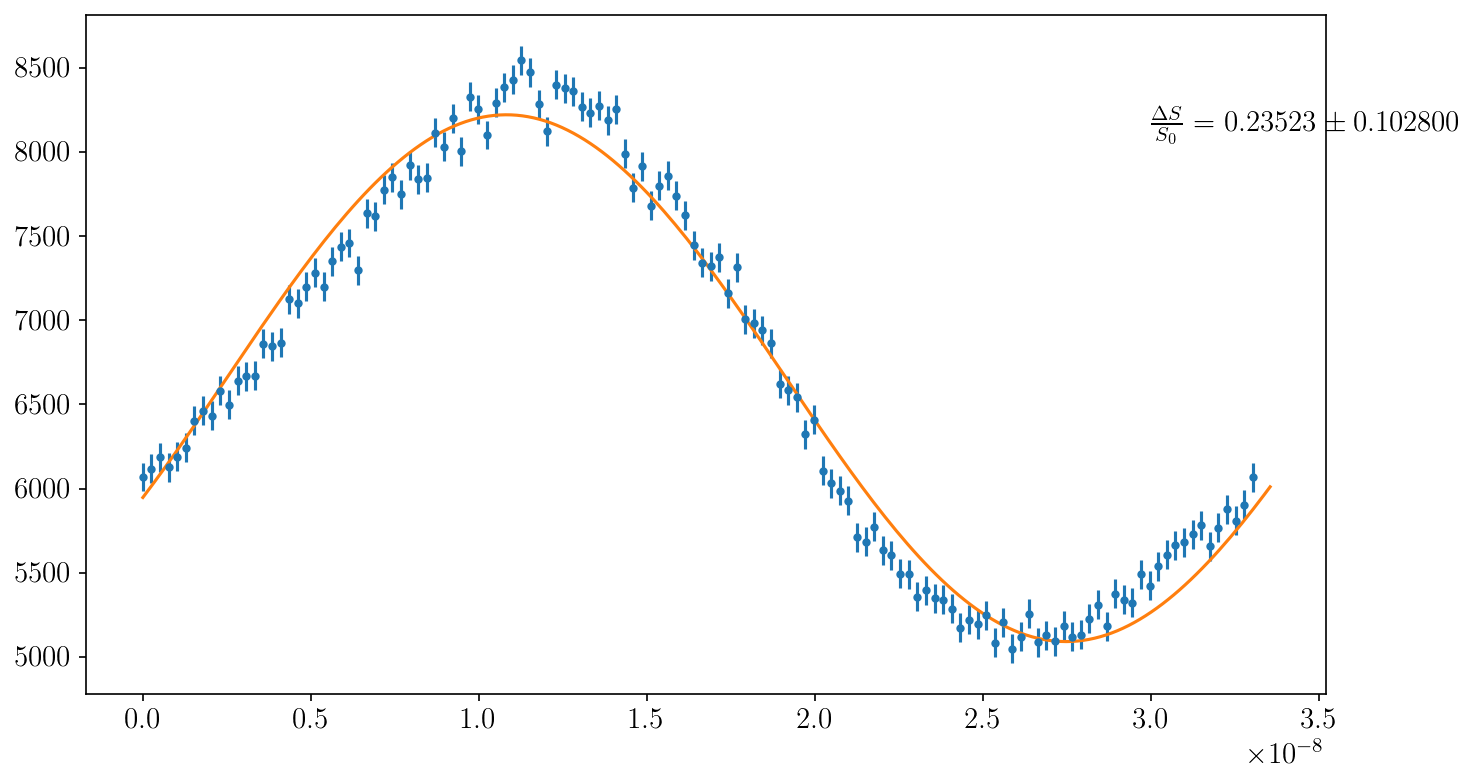

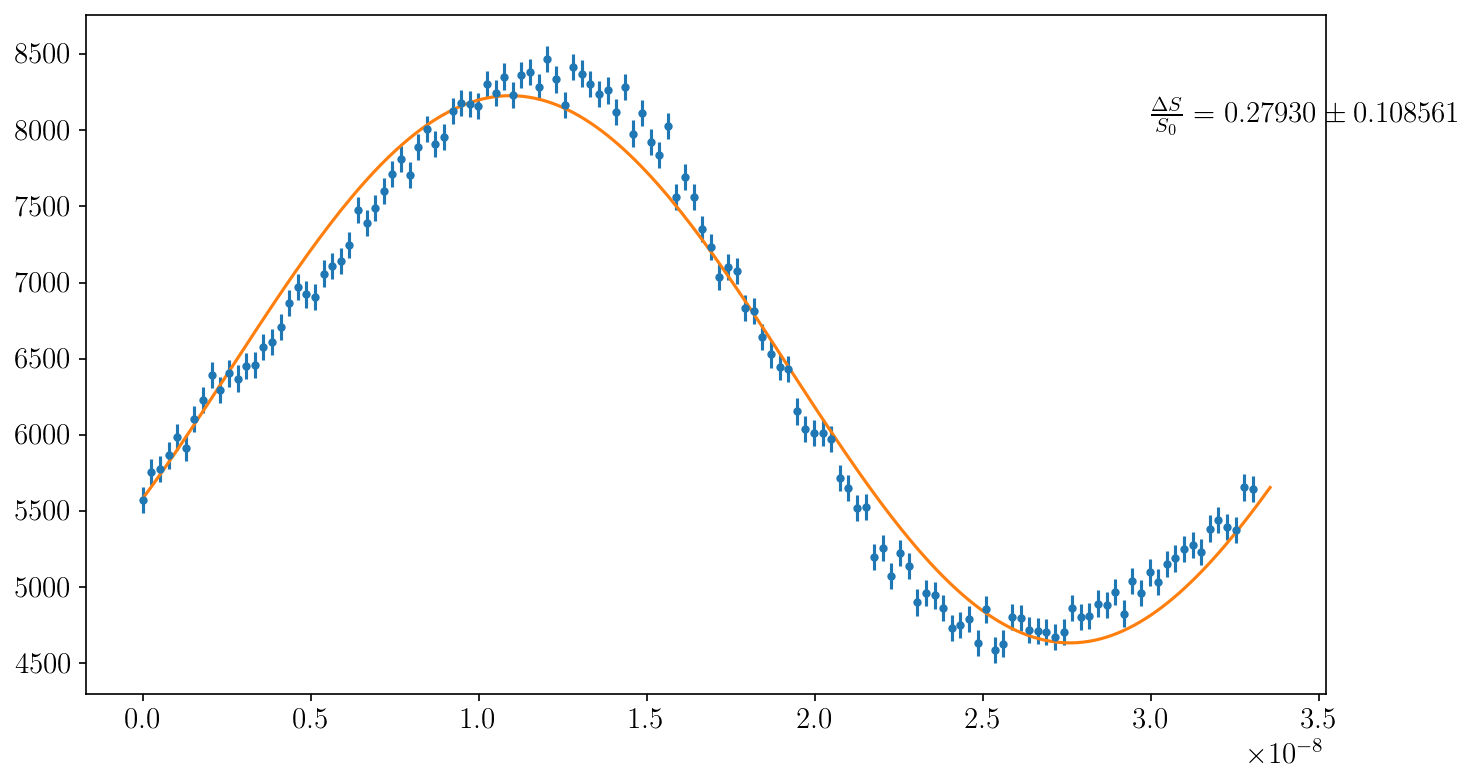

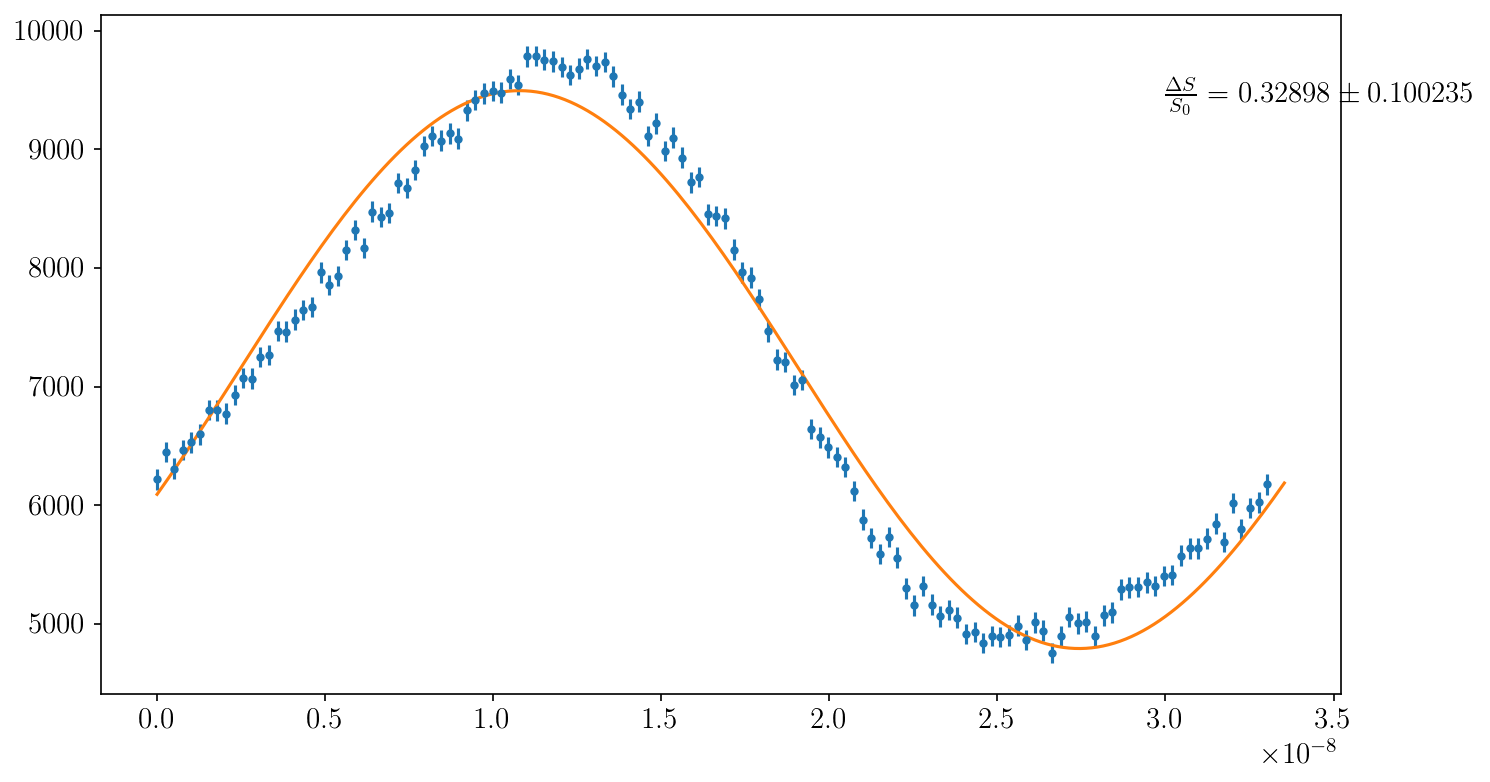

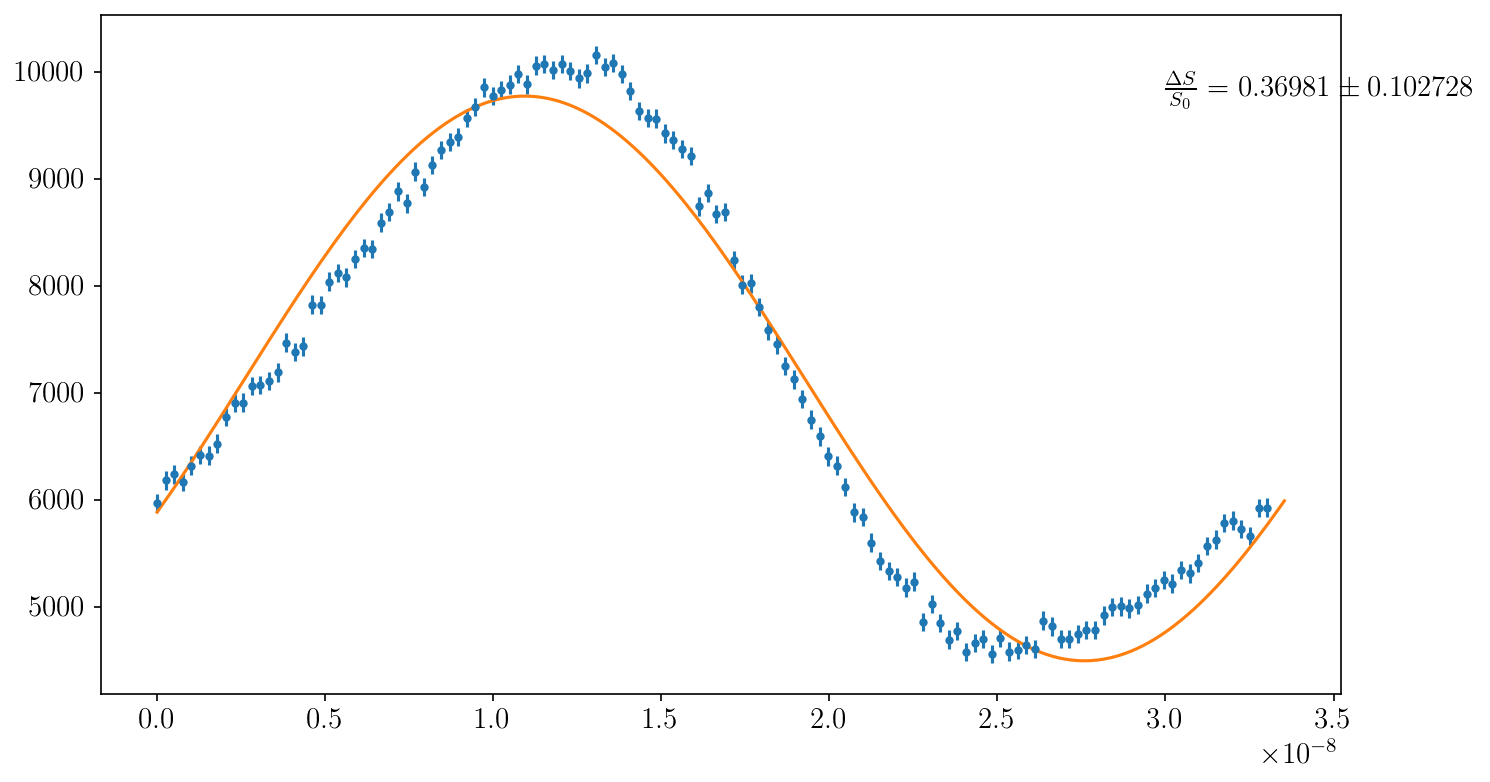

In [85]:
# plot fitu vcetne errorbaru
my_dpi = 150
siz = 100
sizex = 16*siz
sizey = 9*siz
# plot techto fitu
time_fit = np.linspace(0, t_scale.max(), 200)

for i in range(fotkor_shape[1]):
    
    fotkor_fit = fit_func(x[:,i], Omega, time_fit)
    
    plt.figure(figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)
    plt.errorbar(t_scale[:fotkor_shape[0]-2],fotkor_bezcond[:fotkor_shape[0]-2,i],yerr=1/np.sqrt(W_vec),fmt='.')
    plt.plot(time_fit, fotkor_fit)
    text = r'$\frac{\Delta S}{S_0}  = \,\,$' + r'${:.5f} \pm {:.6f}$'.format(x[1,i]/x[0,i], Delta_S_S_ratio_sigma[i])
    plt.text(3e-8, fotkor_bezcond[:,i].max()-500,text) 


Vykresleni vysledne zavislosti.

In [86]:
alpha_bezcond = (voltages_bezcond[:,0] - voltages_bezcond[:,1]) / (voltages_bezcond[:,0] + voltages_bezcond[:,1])
a = 0.000357087248516796
b = 0.0000614272209845667
c = 0.000214572720416111

z_bezcond = a* alpha_bezcond + b* alpha_bezcond**3 + c *alpha_bezcond**5

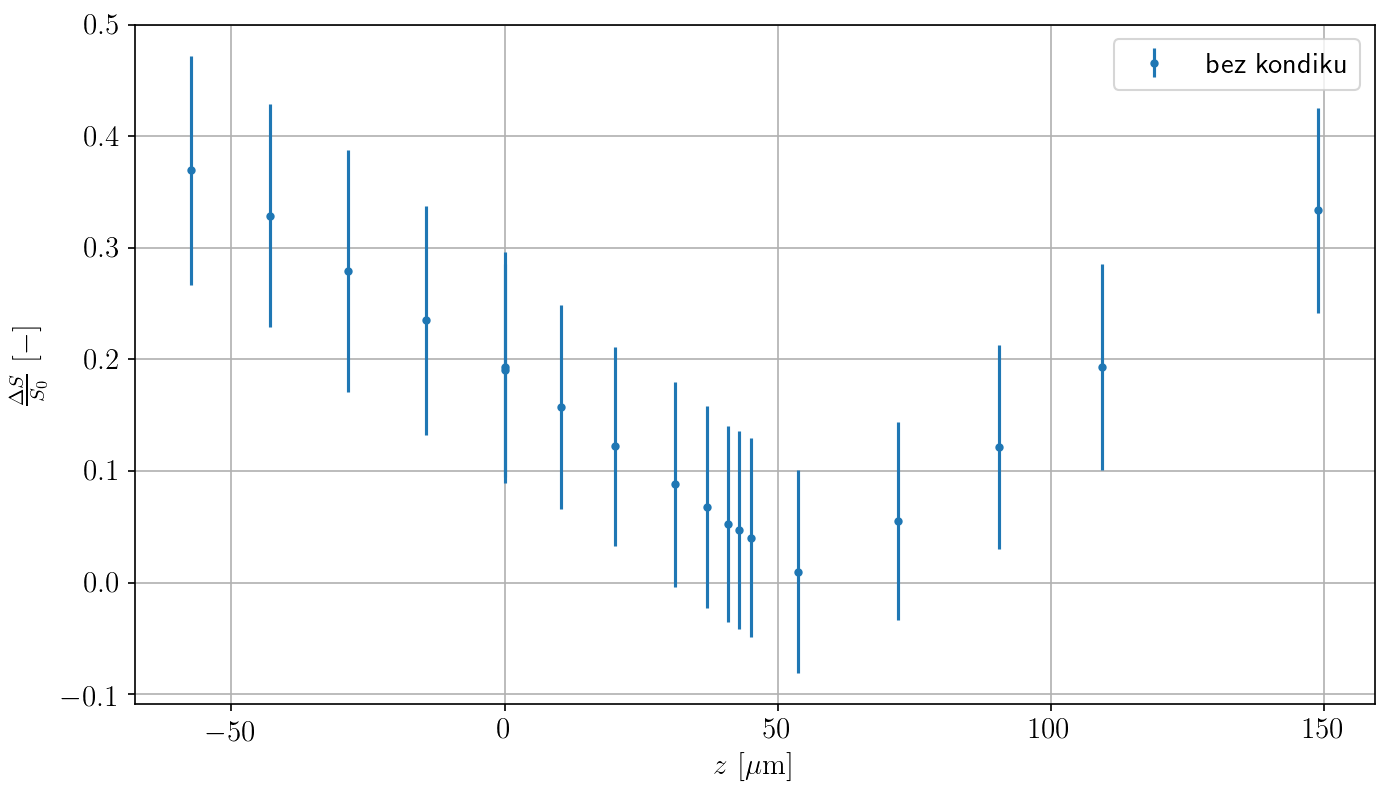

In [90]:
plt.figure(figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)
plt.errorbar(z_bezcond*1e6, np.abs(DeltaS_S_ratio), yerr=Delta_S_S_ratio_sigma, fmt='.', label="bez kondiku")
#plt.errorbar(z_bezcond*1e6, DeltaS_S_ratio, yerr=Delta_S_S_ratio_sigma, fmt='.', label="bez kondiku")
plt.xlabel(r"$ z \, \, \rm [\mu m]$")
plt.ylabel(r"$ \frac{\Delta S}{S_0} \, \, \rm [-]$")

plt.legend()
plt.grid()

Je nutno poresit errorbary jdouci pod nulu.

## Vypocet el. pole

Nejprve zadam potrebne parametry: detuning cooling laseru, decay rate cooling prechodu, omega, a $\Delta S/S_0$.

In [122]:
decay_rate = 132e6  # units 2*pi * decay freq
laser_detun = -30e6 * 2*np.pi  # detuning 
laser_detun_sigma = 5e6 * 2*np.pi # sigma detun

In [123]:
# dalsi parametry
m = 40 * 1.66053904e-27 # calcium mass
k_vec = 2*np.pi / 397e-9 # wave vector
e = 1.60217662e-19 # elem charge

In [143]:
# fce pro fit
from scipy.optimize import fsolve
from scipy.special import j0, j1

def get_A(decay_rate, detun):
    # returns driven oscillator amplitude in point given by detun param.
    return 1 / 2 * (decay_rate / 2 - detun * 1j) / (detun ** 2 + (decay_rate / 2) ** 2)


def fl_signal(beta, laser_detun, Omega, decay_rate):
    # function calculates deltaS/S0 photon-correlation signal
    # input: beta, laser detuning, RF drive freq, decay rate
    A_minus = get_A(decay_rate, laser_detun - Omega)
    A_plus = get_A(decay_rate, laser_detun + Omega)
    A = get_A(decay_rate, laser_detun)

    numer = 2 * j0(beta) * j1(beta) * np.absolute(np.conj(A) * A_plus - A * np.conj(A_minus))
    denom = j0(beta) ** 2 * np.absolute(A) ** 2 + j1(beta) ** 2 * (np.absolute(A_plus) ** 2 + np.absolute(A_minus) ** 2)

    return numer / denom

def get_beta(Omega, decay_rate, laser_detun, norm_mod_amp):
    # function calculates the corresponding beta for given known parameters
    # input: drive frequency, decay_rate, laser detuning, normalized modulation amplitude given by ph_corr_signal
    # output: float value of beta
    def root_func(beta, laser_detun, Omega, decay_rate, norm_mod_amp):
        return fl_signal(beta, laser_detun, Omega, decay_rate) - norm_mod_amp

    sol = fsolve(root_func, np.array([0]), args=(laser_detun, Omega, decay_rate, norm_mod_amp), full_output=1)
    return float(sol[0])

In [145]:
# get beta
#from photon_correlation_functions import get_beta

beta = np.zeros(fotkor_shape[1])
for k in range(fotkor_shape[1]):
    beta[k] = get_beta(Omega, decay_rate, laser_detun, DeltaS_S_ratio[k])
    
# get E-fields
E_rf = m*Omega**2 / (k_vec*e) * beta

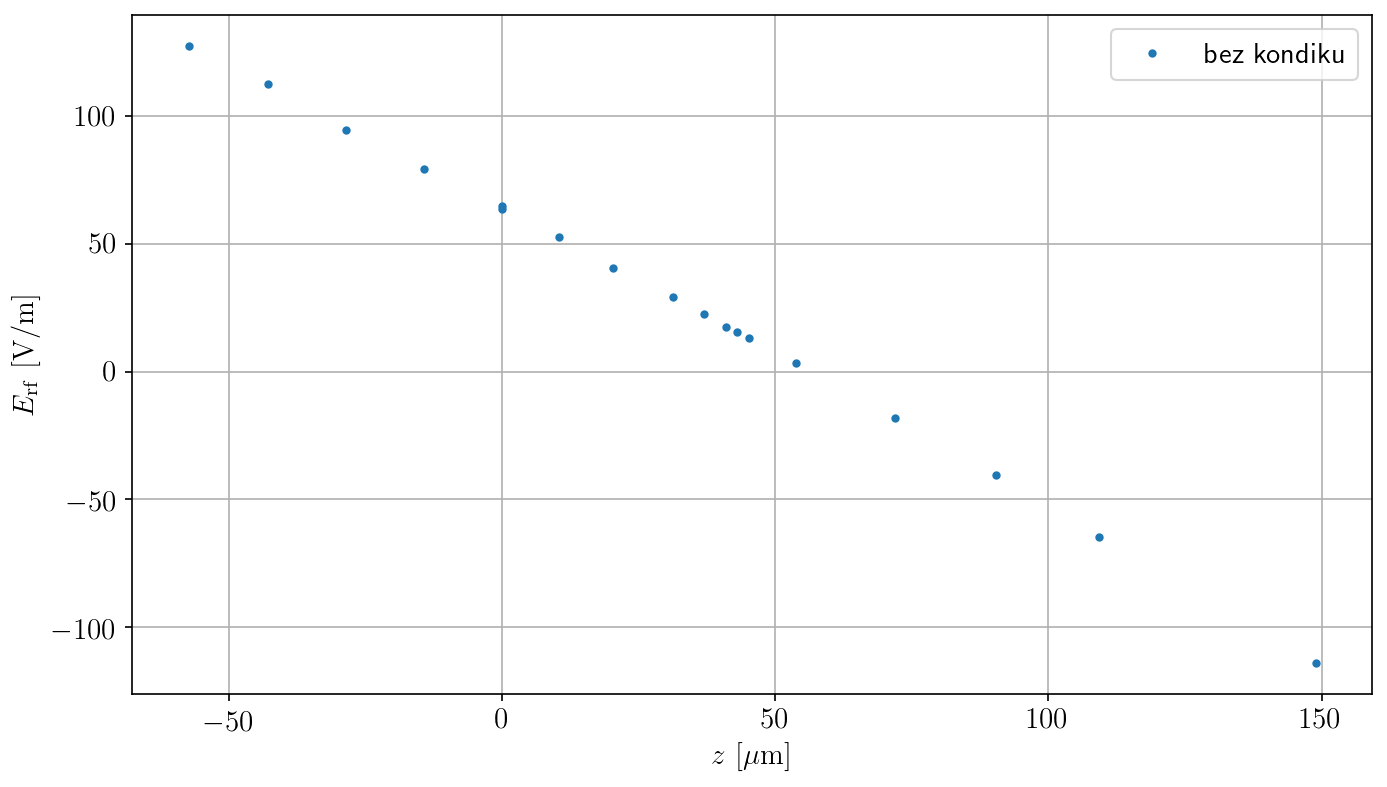

In [216]:
plt.figure(figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)
#plt.errorbar(z_bezcond*1e6, np.abs(DeltaS_S_ratio), yerr=Delta_S_S_ratio_sigma, fmt='.', label="bez kondiku")
plt.plot(z_bezcond*1e6, E_rf,'.', label="bez kondiku")
plt.xlabel(r"$ z \, \, \rm [\mu m]$")
plt.ylabel(r"$ E_{\rm rf} \, \, \rm [V/m]$")

plt.legend()
plt.grid()

## odhad nejistoty pomoci sireni chyb

Vyuzijeme nelinearniho sireni chyb. Tedy
\begin{equation}
    \mathcal{\Sigma}^\beta = \mathcal{J}^\beta \mathcal{\Sigma} \mathcal{J }^{\beta \rm T}
\end{equation}

Kde jakobian $\mathbf{J^\beta}$ ma tvar:
\begin{equation}
	\mathcal{J}^\beta = 
	\begin{pmatrix}
		\frac{\partial \beta}{\partial \left(\frac{\Delta S}{S_0}\right)} & \frac{\partial \beta}{\partial \Omega}      & \frac{\partial \beta}{\partial \Delta}   \\
    \end{pmatrix}
	\quad .
\end{equation}

Kovariancni matice $\mathcal{\Sigma}$ ma tvar:
\begin{equation}
	\mathcal{\Sigma} = 
	\begin{pmatrix}
		\sigma_{\frac{\Delta S}{S_0}}^2 & 0      & 0   \\
        0 & \sigma_{\Omega}^2      & 0   \\
        0 & 0      & \sigma_{\Delta}^2   \\
    \end{pmatrix}
	\quad .
\end{equation}

Jakobian $\mathcal{J}^\beta$ vyjadrime pomoci jakobianu $\mathcal{J}^g$, kde $g(\frac{\Delta S}{S_0}, \Omega, \Gamma, \Delta, \beta)=0$, coz je rovnice, kterou resime numericky.

In [208]:
from scipy.optimize import approx_fprime

def root_func(x):
    [norm_mod_amp, Omega, decay_rate, laser_detun, beta] = x
    return fl_signal(beta, laser_detun, Omega, decay_rate) - norm_mod_amp

# get beta
#from photon_correlation_functions import get_beta

beta = np.zeros(fotkor_shape[1])
beta_sigma = np.zeros(fotkor_shape[1])
for k in range(fotkor_shape[1]):
    beta[k] = get_beta(Omega, decay_rate, laser_detun, DeltaS_S_ratio[k])

    # aproximation of jacobian fce g

    jacob_g = approx_fprime([DeltaS_S_ratio[k], Omega, decay_rate, laser_detun, beta[k]], root_func, 
                  np.array([beta[k], laser_detun, Omega, decay_rate, DeltaS_S_ratio[k]])*8e-7)

    jacob_beta = 1/jacob_g[4] * jacob_g[:4]  

    # definice kovar. matice sigma:

    sigma_matrix = np.diag([Delta_S_S_ratio_sigma[k]**2, Omega_sigma**2, 0, laser_detun_sigma**2])
    covar_beta = jacob_beta @ sigma_matrix @ np.transpose(jacob_beta)
    beta_sigma[k] = np.sqrt(covar_beta)

In [214]:
# get E-fields with unc as well
# get E-fields
E_rf = m*Omega**2 / (k_vec*e) * beta
E_rf_sigma = np.sqrt( (beta_sigma*m*Omega**2 / (k_vec*e))**2 + (2*m*Omega / (k_vec*e) * beta * Omega_sigma)**2  ) # propagase chyb

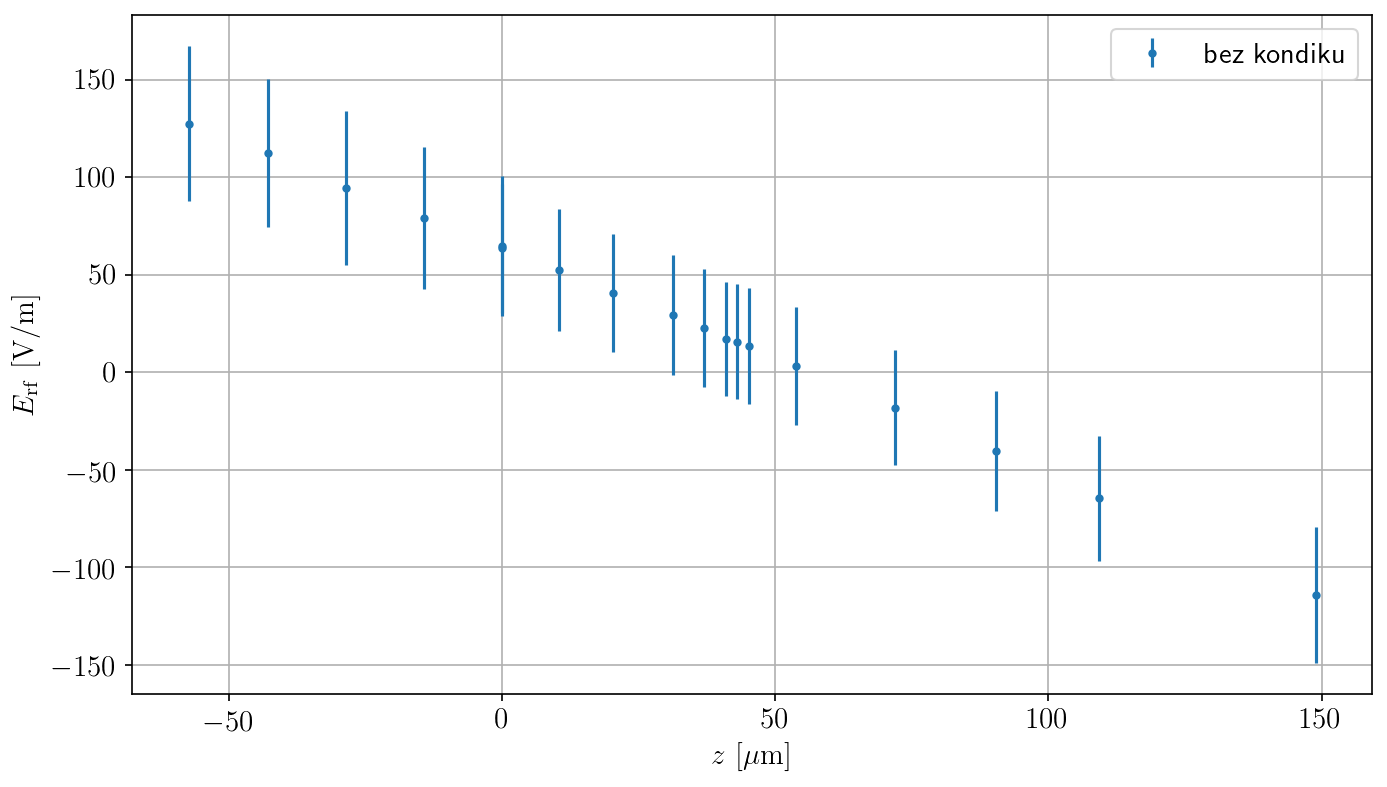

In [218]:
plt.figure(figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)
plt.errorbar(z_bezcond*1e6, E_rf, yerr=E_rf_sigma, fmt='.', label="bez kondiku")
#plt.plot(z_bezcond*1e6, E_rf,'.', label="bez kondiku")
plt.xlabel(r"$ z \, \, \rm [\mu m]$")
plt.ylabel(r"$ E_{\rm rf} \, \, \rm [V/m]$")

plt.legend()
plt.grid()